In [36]:
from brian2 import *
#import numpy as np
# from matplotlib import pyplot as plt
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib import animation
%matplotlib inline

In [2]:
from brian2tools import *

ModuleNotFoundError: No module named 'brian2tools'

Excitatory Neurons:
$$ \tau_m^+ \frac{\phi^P(\vec r, t+\Delta t)  - \phi^p(\vec r, t)}{\Delta t} + \phi^P(\vec r, t) = \Sigma_{P', \vec r'} w^+(\vec r - \vec r' - \xi \vec e^P)s^{P'}(\vec r', t - \tau_s^{++}) + \Sigma_{\vec r'}w^-(\vec r - \vec r')s^-(\vec r', t - \tau_s^-) + a^+(\vec r)[1 + \alpha E^P \bullet V(t)] + \zeta^P(\vec r, t)  $$

Inhibitory Neurons:
$$ \tau_m^+ \frac{\phi^-(\vec r, t+\Delta t)  - \phi^-(\vec r, t)}{\Delta t} + \phi^-(\vec r, t) = \Sigma_{P', \vec r'} w^+(\vec r - \vec r' - \xi \vec e^P)s^{P'}(\vec r', t - \tau_s^{++}) + a^-(t) + \zeta^-(\vec r, t)  $$

Synaptic connectivity from excitatory to all neurons
$$ w^+(\vec r) = \begin{cases}
                w_{mag} ^+{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < rw+\\
                0          & \text{; } r\geq rw+
         \end{cases}
                $$
Synaptic connectivity from inhibitory to excitatory neurons
$$ w^-(\vec r) = \begin{cases}
                -w_{mag} ^-{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < 2rw-\\
                0          & \text{; } r\geq 2rw-
         \end{cases}
                $$

$$ a^+(\vec r) = \begin{cases}
                -a_{min}^+ + (a^+_{max} - a^+_{min})^{\frac{1 + cos(\pi \rho /\rho_{a^+})}{2}}& \text{; } \rho < \rho a+\\
                a_{min}^+          & \text{; } \rho \geq \rho a+.
         \end{cases}
                $$

$$ a^-(t) = a_{mag}^- - a_{th}^-cos(t\pi ft + \psi_0)  $$

$$ \rho = \frac{\sqrt{(x - \frac{n+1/2}{2}^2 + (y - \frac{n+1}{2}^2)}}{n/2} $$

In [3]:
# start_scope() # creat a new scope


# # Parameters
# n = 40
# N = 232 * 232 # Neurons per population
# N = n * n

# tau_m_plus = 40*ms # Exc. membrane time constant
# tau_m_minus = 20*ms # Inh. membrane time constant
# tau_s_plus_plus = 5*ms # Exc.-to-exc. synaptic delay
# tau_s_minus_plus = 2*ms # Exc.-to-inh. synaptic delay
# tau_s_minus = 2*ms # Inh. synaptic delay
# a_max_plus = 2 # Exc. drive maximum
# a_min_plus = 0.8 # Exc. drive minimum
# rho_a_plus = 1.2 # Exc. drive scaled speed
# a_mag_minus = 0.72 # Inh. drive magnitude
# a_th_minus = 0.2 # Inh. drive theta amplitude
# f = 8*hertz # Inh. drive theta frequency
# w_mag_plus = 0.2 # Exc. synaptic strength
# r_w_plus = 6 # Exc. synaptic spread
# w_mag_minus = 2.8 # Inh. synaptic strength
# r_w_minus = 12 # Inh. synaptic distance
# xi = 3 # Exc. synaptic shift
# alpha = 0.25*second/metre # Exc. velocity gain
# var_zeta_P = 0.002**2 # Exc. noise magnitude
# var_zeta_I = 0.002**2 # Inh. noise magnitude


# duration = 1000*ms


#### Scaled Parameters

In [4]:
start_scope() # creat a new scope


# Parameters
n = 40
N = 232 * 232 # Neurons per population
N = n * n

tau_m_plus = 40*ms # Exc. membrane time constant
tau_m_minus = 20*ms # Inh. membrane time constant
tau_s_plus_plus = 5*ms # Exc.-to-exc. synaptic delay
tau_s_minus_plus = 2*ms # Exc.-to-inh. synaptic delay
tau_s_minus = 2*ms # Inh. synaptic delay
a_max_plus = 2 # Exc. drive maximum
a_min_plus = 0.8 # Exc. drive minimum
rho_a_plus = 1.2 # Exc. drive scaled speed
a_mag_minus = 0.72 # Inh. drive magnitude
a_th_minus = 0.2 # Inh. drive theta amplitude
f = 8*hertz # Inh. drive theta frequency
w_mag_plus = 0.2 # Exc. synaptic strength
r_w_plus = (6/232) * n # Exc. synaptic spread
w_mag_minus = 2.8 # Inh. synaptic strength
r_w_minus = (12/232) * n # Inh. synaptic distance
xi = (3/232) * n # Exc. synaptic shift
alpha = 0.25*second/metre # Exc. velocity gain
var_zeta_P = 0.002**2 # Exc. noise magnitude
var_zeta_I = 0.002**2 # Inh. noise magnitude


duration = 1000*ms


In [5]:
defaultclock.dt = 0.1*ms

### Velocity Inputs (Based on Rat Trajectory):
Two options:
1. Simulate the inputs (as done by Mittal & Narayanan, 2021)
2. Differentiate rat trajectories (as done by Burak & Fiete, 2009 and used in Kang & DeWeese 2019)


In [6]:
@implementation('numpy', discard_units=True)
@check_units(dir_x = metre, dir_y = metre, V_x = metre/second, V_y = metre/second, result= metre/second)
def dot_product(dir_x, dir_y, V_x, V_y):
    dir = [dir_x, dir_y]
    V = [V_x, V_y]
    product = dot(dir, V)
    print(product)
    return product * metre / second


In [7]:
dot_product(3 * metre, 2*metre, 1*metre/second, 5*metre/second)

13.0


13. * metre / second

In [8]:
eqns_exc_n = '''

x = i % sqrt(N) * metre : metre 
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = 0 * metre : metre
dir_y = 1 * metre: metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1

'''

eqns_exc_s = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = 0 * metre : metre
dir_y = -1 * metre : metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)
 
a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1
'''

eqns_exc_e = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = 1 * metre : metre
dir_y = 0 * metre : metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1
'''

eqns_exc_w = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = -1 * metre : metre
dir_y = 0 * metre : metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1
'''


""" 
eqns_exc = '''

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus/tau_m_plus : 1

'''  """

eqns_inh = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

dv/dt = -(v - a_minus)/tau_m_minus + var_zeta_I*xi*tau_m_minus**-0.5 : 1
a_minus = a_mag_minus - a_th_minus*cos(2*pi*f*t): 1

'''

reset = '''
v = 0
'''


In [9]:

#@check_units(i = 1, result = [metre for x in range(len(i))])
@check_units(i = 1, N = 1, result = metre)
def location_x(i, N):
    x = i % N
    return x * metre

@check_units(i = 1, N = 1, result = metre)
def location_y(i, N):
    y = i // N
    return y * metre

@implementation('numpy', discard_units=True)
@check_units(x = 1, y = 1, N = 1, result = metre)
def rho_value(x, y, N):

    value = sqrt(((x - ((N+1)/2))**2 + (y - ((N+1)/2))**2)/(N/2))

    return value * metre

""" @implementation('numpy', discard_units=True)
@check_units(rho = 1, result = 1)
def a_plus_value(rho):

    value = a_min_plus * ones_like(rho)
    for i in range(len(rho)):
        if rho[i] < rho_a_plus:
            value[i] = (a_max_plus - a_min_plus) * (1 - cos(pi*rho[i]/rho_a_plus))
    return value """

@implementation('numpy', discard_units=True)
@check_units(rho = 1, result = 1)
def a_plus_value(rho):

    if rho < rho_a_plus:
        value = (a_max_plus - a_min_plus) * (1 - cos(pi*rho/rho_a_plus))
    else:
        value = a_min_plus
    
    return value

@check_units(x = 1, y = 1, result = metre)
def dir_array(x, y, N):
    x_array = x * ones(N)
    y_array = y * ones(N)

    return column_stack((x_array, y_array)) * metre

In [10]:
# Neural Populations

## North
P_n = NeuronGroup(N, eqns_exc_n, threshold='v > 1', reset=reset, method='euler')
P_n.v = 'rand()'

## South
P_s = NeuronGroup(N, eqns_exc_s, threshold='v > 1', reset=reset, method='euler')
P_s.v = 'rand()'

## East
P_e = NeuronGroup(N, eqns_exc_e, threshold='v > 1', reset=reset, method='euler')
P_e.v = 'rand()'

## West
P_w = NeuronGroup(N, eqns_exc_w, threshold='v > 1', reset=reset, method='euler' )
P_w.v = 'rand()'

## Inhibitory
P_i = NeuronGroup(N, eqns_inh, threshold='v > 1', reset=reset, method='euler' )
P_i.v = 'rand()'

M_n = SpikeMonitor(P_n)
M_s = SpikeMonitor(P_s)
M_e = SpikeMonitor(P_e)
M_w = SpikeMonitor(P_w)
M_i = SpikeMonitor(P_i)

State_i = StateMonitor(P_i, 'v', record=True)
State_n = StateMonitor(P_n, 'v', record=True)
State_e = StateMonitor(P_e, 'v', record=True)
State_w = StateMonitor(P_w, 'v', record=True)
State_s = StateMonitor(P_s, 'v', record=True)



In [11]:
P_n.dir_x

<neurongroup.dir_x: 0. * metre>

In [12]:
for name, var in sorted(P_n.variables.items()):
    print('%s : %s' % (name, var))  

N : <Constant(dimensions=Dimension(),  dtype=int64, scalar=True, constant=True, read_only=True)>
_spikespace : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=False, constant=False, read_only=False)>
a_plus : <ArrayVariable(dimensions=Dimension(),  dtype=float64, scalar=False, constant=False, read_only=False)>
dir_x : <Subexpression(name='dir_x', dimensions=metre, dtype=<class 'numpy.float64'>, expr='0 * metre', owner=<neurongroup>)>
dir_y : <Subexpression(name='dir_y', dimensions=metre, dtype=<class 'numpy.float64'>, expr='1 * metre', owner=<neurongroup>)>
dt : <ArrayVariable(dimensions=second,  dtype=float, scalar=True, constant=True, read_only=True)>
i : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=False, constant=True, read_only=True)>
rho : <ArrayVariable(dimensions=metre,  dtype=float64, scalar=False, constant=False, read_only=False)>
t : <ArrayVariable(dimensions=second,  dtype=float64, scalar=True, constant=False, read_only=True)>
t_in_timesteps : <Ar

### Synaptic Connectivity Matrix
Synaptic connectivity from excitatory to all neurons
$$ w^+(\vec r) = \begin{cases}
                w_{mag} ^+{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < rw+\\
                0          & \text{; } r\geq rw+
         \end{cases}
                $$
Synaptic connectivity from inhibitory to excitatory neurons
$$ w^-(\vec r) = \begin{cases}
                -w_{mag} ^-{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < 2rw-\\
                0          & \text{; } r\geq 2rw-
         \end{cases}
                $$

### New Synapse Groups

In [13]:
S = []
exc_populations = [P_n, P_e, P_w, P_s]
all_populations = [P_n, P_e, P_w, P_s, P_i]
index = 0

exc_to_all_model = """
                    r = sqrt((x_post - x_pre)**2 + (y_post - y_pre)**2) : 1 (constant over dt)
                    w = w_mag_plus**((1 + cos(pi*r/r_w_plus))/2) : 1 (constant over dt)
                    """
inh_to_exc_model = '''
                    r = sqrt((x_post - x_pre)**2 + (y_post - y_pre)**2) : 1 (constant over dt)
                    w = - w_mag_minus**((1 + cos(pi*r/r_w_plus))/2) : 1 (constant over dt)
                    '''


print("Setting exc >> all connections")
for src in exc_populations:
    for trg in all_populations:
        print("Synapse group index:", index)
        S.append(Synapses(src, trg, exc_to_all_model, on_pre='v_post += w'))
        if src == trg:
            S[index].connect(condition='sqrt((x_post - x_pre)**2 + (y_post - y_pre)**2)/metre < r_w_plus and i!=j')
        else:
            S[index].connect(condition='sqrt((x_post - x_pre)**2 + (y_post - y_pre)**2)/metre < r_w_plus')
        
        # Synaptic Delay
        if trg != P_i:
            S[index].delay = tau_s_plus_plus
        else:
            S[index].delay = tau_s_minus_plus
        
        index += 1

# Inhibitory to excitatory connections
print("Setting inh >> exc connections")
for trg in exc_populations:
    print("Synapse group index:", index)
    S.append(Synapses(P_i, trg, inh_to_exc_model, on_pre = 'v_post += w'))
    S[index].connect(condition = 'sqrt((x_post - x_pre)**2 + (y_post - y_pre)**2)/metre < 2 * r_w_minus')
    S[index].delay = tau_s_minus
    index += 1
    


Setting exc >> all connections
Synapse group index: 0
Synapse group index: 1
Synapse group index: 2
Synapse group index: 3
Synapse group index: 4
Synapse group index: 5
Synapse group index: 6
Synapse group index: 7
Synapse group index: 8
Synapse group index: 9
Synapse group index: 10
Synapse group index: 11
Synapse group index: 12
Synapse group index: 13
Synapse group index: 14
Synapse group index: 15
Synapse group index: 16
Synapse group index: 17
Synapse group index: 18
Synapse group index: 19
Setting inh >> exc connections
Synapse group index: 20
Synapse group index: 21
Synapse group index: 22
Synapse group index: 23


In [14]:
# def exc_to_any_connectivity(N, dir_x, dir_y, same_pop=False):
#     """
#     Sets up the connectivity matrix between two excitatory populations.
#     N - number of neurons in each population
#     dir - directional tuning vector of pre_synaptic population
#     """
#     connectivity = zeros((N, N))
#     # connectivity = zeros(N**2) 
#    # dir = eval(dir) # convert string representation to list
#     for i in range(N): # looping over source neurons
#         i_x = i % N
#         i_y = i // N
#         for j in range(N): # looping over target neurons
#             j_x = j % N
#             j_y = j % N
            
#             if same_pop and i ==  j:
#                 connectivity[i, j] = 0
#             else:
#                 r_x = j_x - i_x - xi*dir_x
#                 r_y = j_y - i_y - xi*dir_y
#                 distance = linalg.norm(array([r_x, r_y]))

#                 if distance < r_w_plus:
#                     # connectivity[i, j] = w_mag_plus**(1 + cos(pi*sqrt((j_x - i_x - xi*dir_x)**2 + (j_y - i_y - xi*dir_y)**2)))
#                     connectivity[i, j] = w_mag_plus**((1 + cos(pi*distance/r_w_plus))/2)

#     return connectivity.flatten()


# def inh_to_exc_connectivity(N):
#     """
#     Sets up the connectivity matrix between two excitatory populations.
#     N - number of neurons in each population
#     dir - directional tuning vector of pre_synaptic population
#     """
#     connectivity = empty((N, N))

#     for i in range(N): # looping over source neurons
#         i_x = i % N
#         i_y = i // N
#         for j in range(N):
#             j_x = j % N
#             j_y = j % N

#             r_x = j_x - i_x 
#             r_y = j_y - i_y 
#             distance = linalg.norm(array([r_x, r_y]))

#             if distance < 2*r_w_minus:
#                 connectivity[i, j] = -w_mag_minus**((1 + cos(pi*distance/r_w_minus))/2)

#     return connectivity.flatten()

In [15]:
# S = [] # to store  the 25 synapse classes
# exc_populations = [P_n, P_s, P_e, P_w]
# all_populations = [P_n, P_s, P_e, P_w, P_i]
# index = 0

# # Set connections from excitatory to excitatory populations: (Total 16 iterations)
# print("Setting up exc-->exc connections")
# for src in exc_populations:
#     print("Source population:", src.name)
#     for trg in exc_populations:
#         print("Target population:", trg)
#         S.append(Synapses(src, trg, 'w: 1', on_pre='v_post += w'))
#         if src == trg: # connection within the population     
#             S[index].connect(condition='i!=j') # if connection within population, don't connect neurons to themselves
#             # connectivity = exc_to_any_connectivity(N, src.dir, same_pop=True)
#             # S[index].w = 'connectivity[i, j]'
#             S[index].w = delete(exc_to_any_connectivity(N, src.dir_x/metre, src.dir_y/metre, same_pop=True).flatten(), range(0, N*N, N+1), 0) # deletes diagonal entries of connectivity before assigning it to weights
#         else:
#             S[index].connect() # if connections are between two populations, connect all neurons
#             # connectivity = exc_to_any_connectivity(N, src.dir)
#             # S[index].w = 'connectivity[i, j]'
#             S[index].w = exc_to_any_connectivity(N, src.dir_x/metre, src.dir_y/metre).flatten()
#         S[index].delay = 'tau_s_plus_plus'
#         index += 1

# # Set connections from excitatory to inhibitory population: (Total 4 iterations)
# print("Setting up exc-->inh connections")
# for i in exc_populations:
#     S.append(Synapses(i, P_i, 'w:1', on_pre='v_post += w'))
#     S[index].connect()
#     # connectivity = exc_to_any_connectivity(N, src.dir)
#     # S[index].w = 'connectivity[i, j]'
#     S[index].w = exc_to_any_connectivity(N, src.dir_x/metre, src.dir_y/metre).flatten()
#     S[index].delay = 'tau_s_minus_plus'
#     index += 1    

# # Set connections from inhibitory to excitatory neurons: (Total 4 iterations)
# print("Setting up inh-->exc connections")
# for i in exc_populations:
#     S.append(Synapses(P_i, i, 'w:1', on_pre='v_post += w'))
#     S[index].connect()
#     # connectivity = inh_to_exc_connectivity(N)
#     # S[index].w = 'connectivity[i, j]'
#     S[index].w = inh_to_exc_connectivity(N).flatten()
#     S[index].delay = 'tau_s_minus'
#     index += 1

# # The inhibitory population doesn't have recurrent connections within itself


### Simulation Protocol
* Each neuron initialised to a random potential between 0 & 1
* 500 timesteps without velocity input to generate grid like pattern
* 3 evolutions of timesteps with constant velocity input of 0.5m/sec at angles $\pi/2 - \pi/5, 2\pi/5, and \pi/4$ successively.
* Evolve the network for 4 laps without idle periods. (What is a lap?)

Where to get the velocity inputs from?

### Plot grid cell activity

Ways to do this:
1. Bin spiking activity in some time window and plot as heatmap on top of neural sheet (for any particular timewindow)
2. 

WARNING    /tmp/ipykernel_203989/3269079977.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot(velocity_array_x[0], velocity_array_y[0], 'ro', color='black', label='start')
 [py.warnings]
WARNING    /tmp/ipykernel_203989/3269079977.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot(velocity_array_x[-1], velocity_array_y[-1], 'ro', color='blue', label='stop')
 [py.warnings]


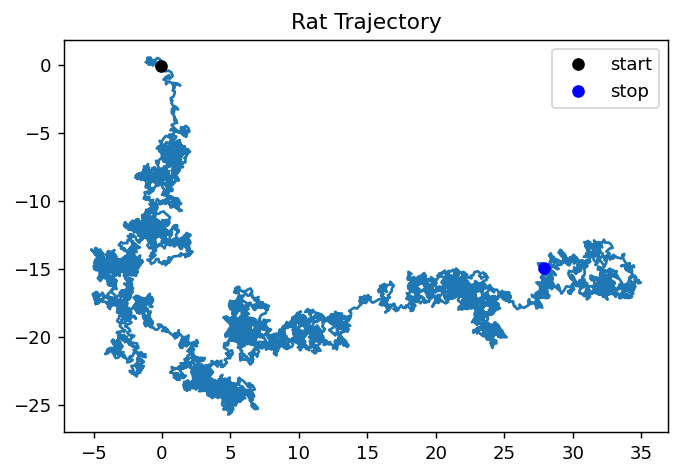

In [16]:
#@title Simulated Velocity Inputs:

def simulate_random_velocity(duration, dt, step_size):
    """
    Inputs
    
    """
    x = step_size * cumsum((random(int(duration/dt)) - 0.5))
    y = step_size * cumsum((random(int(duration/dt)) - 0.5))

    # velocity = column_stack((x, y))

    return x / second, y / second

step_size = 0.5*metre
dt = 0.1*ms
velocity_array_x, velocity_array_y = simulate_random_velocity(duration, dt, step_size)


figure(dpi=130)
plot(velocity_array_x[:], velocity_array_y[:])
plot(velocity_array_x[0], velocity_array_y[0], 'ro', color='black', label='start')
plot(velocity_array_x[-1], velocity_array_y[-1], 'ro', color='blue', label='stop')
title("Rat Trajectory")
legend()



In [17]:
V_x = TimedArray(velocity_array_x, dt=dt)
V_y = TimedArray(velocity_array_y, dt=dt)

In [18]:
print(V_x(1*second))

27.87123195 m/s


In [19]:
print("Running the simulation")
run(duration)

Running the simulation


WARNING    "xi" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 0.5172413793103449. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 0.5172413793103449. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 0.5172413793103449. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup_4", but also exists in the run namespace with the value 0.5172413793103449. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup", but also exists 

0.10104811401663977
-0.09804939727032663
0.09804939727032663
-0.10104811401663977
-0.10089942080088182
-0.027952835985358027
0.027952835985358027
0.10089942080088182
0.0803264965107931
-0.025852188853639657
0.025852188853639657
-0.0803264965107931
-0.12987665368119994
-0.0027563558339412375
0.0027563558339412375
0.12987665368119994
-0.10019571940332939
0.1365231974474464
-0.1365231974474464
0.10019571940332939
-0.25257965849911146
-0.04384445869347686
0.04384445869347686
0.25257965849911146
-0.42731330936559253
-0.1808406970145771
0.1808406970145771
0.42731330936559253
-0.4900209283340838
-0.35016666389486906
0.35016666389486906
0.4900209283340838
-0.37952954275109785
-0.43505692867022344
0.43505692867022344
0.37952954275109785
-0.25456102675343734
-0.6635382474264941
0.6635382474264941
0.25456102675343734
-0.06030708152764602
-0.7831853418444343
0.7831853418444343
0.06030708152764602
-0.2990321758840058
-0.9602287814649796
0.9602287814649796
0.2990321758840058
-0.16106735186008198
-0.

4.842075145696154
1.114521432312302
-1.114521432312302
-4.842075145696154
4.947960084323241
1.3113671316945297
-1.3113671316945297
-4.947960084323241
5.137647418540053
1.5244604847344814
-1.5244604847344814
-5.137647418540053
5.253240196759055
1.7536563592343013
-1.7536563592343013
-5.253240196759055
5.197504318577557
1.6152253336050495
-1.6152253336050495
-5.197504318577557
5.2826721311653655
1.7755680445297322
-1.7755680445297322
-5.2826721311653655
5.06059681782819
1.7859600664030721
-1.7859600664030721
-5.06059681782819
4.872795796816481
1.589399596812901
-1.589399596812901
-4.872795796816481
5.060002179950686
1.778365065903885
-1.778365065903885
-5.060002179950686
4.896880302953677
2.0012032948283873
-2.0012032948283873
-4.896880302953677
4.666545275514622
1.929796874708201
-1.929796874708201
-4.666545275514622
4.496359934616533
1.7412585633746396
-1.7412585633746396
-4.496359934616533
4.6537336123451105
1.5130322869657995
-1.5130322869657995
-4.6537336123451105
4.779113593633168


7.508486358735712
0.48973491769205213
-0.48973491769205213
-7.508486358735712
7.438347496826893
0.6852377321444079
-0.6852377321444079
-7.438347496826893
7.339676553308972
0.5641793463398528
-0.5641793463398528
-7.339676553308972
7.379092509705593
0.7359032330939437
-0.7359032330939437
-7.379092509705593
7.179172158508989
0.6424874183530427
-0.6424874183530427
-7.179172158508989
6.930222838331976
0.5815865245269588
-0.5815865245269588
-6.930222838331976
7.056643332397769
0.6640842351371503
-0.6640842351371503
-7.056643332397769
6.986264912020761
0.5820981579385588
-0.5820981579385588
-6.986264912020761
7.189224894133742
0.4009004525513556
-0.4009004525513556
-7.189224894133742
7.351664684658443
0.6497621039798083
-0.6497621039798083
-7.351664684658443
7.259444086832084
0.8763780882494578
-0.8763780882494578
-7.259444086832084
7.1091348922866375
1.039494529286939
-1.039494529286939
-7.1091348922866375
6.9713626618419084
1.074042013889982
-1.074042013889982
-6.9713626618419084
6.81651888

6.543967557214984
1.0527526420272357
-1.0527526420272357
-6.543967557214984
6.472613804426002
1.2115865164079516
-1.2115865164079516
-6.472613804426002
6.457617854362619
1.1522431148501293
-1.1522431148501293
-6.457617854362619
6.269069763553291
1.0464426228837165
-1.0464426228837165
-6.269069763553291
6.399893018350279
0.8560525636757321
-0.8560525636757321
-6.399893018350279
6.297336243553804
0.7353697380533295
-0.7353697380533295
-6.297336243553804
6.441684688589037
0.9072433284195145
-0.9072433284195145
-6.441684688589037
6.280272243304788
0.9781204120759251
-0.9781204120759251
-6.280272243304788
6.036711406411655
1.0186924997076683
-1.0186924997076683
-6.036711406411655
6.1441728017498125
0.9794446641336059
-0.9794446641336059
-6.1441728017498125
5.9118927000029675
1.156654133108711
-1.156654133108711
-5.9118927000029675
5.777739026029626
1.3006459593512747
-1.3006459593512747
-5.777739026029626
5.864132149119675
1.1217220623956117
-1.1217220623956117
-5.864132149119675
5.85234628

8.745896332660278
-0.9174250456179758
0.9174250456179758
-8.745896332660278
8.579403708586135
-0.719634168522015
0.719634168522015
-8.579403708586135
8.367407468257031
-0.9358199649593495
0.9358199649593495
-8.367407468257031
8.326831240104427
-1.1111395146281524
1.1111395146281524
-8.326831240104427
8.111872858291962
-1.062619219052613
1.062619219052613
-8.111872858291962
7.983889822194494
-1.163578043973705
1.163578043973705
-7.983889822194494
8.0596559175449
-1.135392637454149
1.135392637454149
-8.0596559175449
8.036632187333772
-1.3176969054382217
1.3176969054382217
-8.036632187333772
7.989005860865121
-1.5576059676438843
1.5576059676438843
-7.989005860865121
8.157046714639986
-1.7810800655944954
1.7810800655944954
-8.157046714639986
8.290151438528634
-1.904971054063156
1.904971054063156
-8.290151438528634
8.401917729322845
-1.787438224399575
1.787438224399575
-8.401917729322845
8.277932236107658
-1.9278538716420723
1.9278538716420723
-8.277932236107658
8.14439128577918
-1.85570722

10.289041576836226
-0.8217838270812843
0.8217838270812843
-10.289041576836226
10.34870491117529
-0.7660759621525293
0.7660759621525293
-10.34870491117529
10.491071032257151
-0.6416876341419984
0.6416876341419984
-10.491071032257151
10.646124350636075
-0.626274691586912
0.626274691586912
-10.646124350636075
10.606096364538969
-0.7481857044489595
0.7481857044489595
-10.606096364538969
10.61504037071019
-0.9775429398685713
0.9775429398685713
-10.61504037071019
10.784297371790274
-1.1832466811921452
1.1832466811921452
-10.784297371790274
10.654657118207085
-1.146535006862746
1.146535006862746
-10.654657118207085
10.775804683450449
-0.9967000639764442
0.9967000639764442
-10.775804683450449
10.921290268223494
-1.0648564524151158
1.0648564524151158
-10.921290268223494
10.688903645988196
-0.9102726058460049
0.9102726058460049
-10.688903645988196
10.79496743245708
-0.7283382855675364
0.7283382855675364
-10.79496743245708
10.556428202116372
-0.8882839941276449
0.8882839941276449
-10.556428202116

0.5147792971698091
-0.5147792971698091
-8.376756277505583
8.13888735341244
0.5060165162204022
-0.5060165162204022
-8.13888735341244
8.302048265020858
0.7527479372384459
-0.7527479372384459
-8.302048265020858
8.125770520094713
0.9111501106711476
-0.9111501106711476
-8.125770520094713
8.178535438854823
0.8170397763157738
-0.8170397763157738
-8.178535438854823
8.218343796923765
0.8548778239022374
-0.8548778239022374
-8.218343796923765
8.005607729444819
0.8383460752759575
-0.8383460752759575
-8.005607729444819
7.796002757063817
0.7056829716307856
-0.7056829716307856
-7.796002757063817
7.572463220925721
0.8138651750204646
-0.8138651750204646
-7.572463220925721
7.494770525926486
0.9850715021630274
-0.9850715021630274
-7.494770525926486
7.399047043735893
0.7855665028855422
-0.7855665028855422
-7.399047043735893
7.166369926419859
0.6509544471518998
-0.6509544471518998
-7.166369926419859
7.324544934581136
0.5362013248296371
-0.5362013248296371
-7.324544934581136
7.262042189720847
0.664985400205

8.380940301587737
0.023033178983960734
-0.023033178983960734
-8.380940301587737
8.425088127665944
-0.120343139808267
0.120343139808267
-8.425088127665944
8.349883242209177
-0.1731111822608728
0.1731111822608728
-8.349883242209177
8.145169784210673
-0.07733471106747919
0.07733471106747919
-8.145169784210673
8.0959147640696
-0.25977839281993403
0.25977839281993403
-8.0959147640696
7.954400590026859
-0.31066424513096474
0.31066424513096474
-7.954400590026859
7.841577523582155
-0.41032648527001486
0.41032648527001486
-7.841577523582155
8.04203043849699
-0.19352742032510223
0.19352742032510223
-8.04203043849699
7.881824724068377
-0.387993726050273
0.387993726050273
-7.881824724068377
8.065455389695405
-0.460554305682631
0.460554305682631
-8.065455389695405
8.295773997520994
-0.29661537099534563
0.29661537099534563
-8.295773997520994
8.430049465478772
-0.1826100509005376
0.1826100509005376
-8.430049465478772
8.262612409425376
-0.27912382071680203
0.27912382071680203
-8.262612409425376
8.0155

6.28671812896242
1.4253410342160793
-1.4253410342160793
-6.28671812896242
6.112833057865635
1.325199034399108
-1.325199034399108
-6.112833057865635
6.295581200053461
1.2047035810833808
-1.2047035810833808
-6.295581200053461
6.43122096548707
1.0227114844048664
-1.0227114844048664
-6.43122096548707
6.44916483619597
1.2107440997307113
-1.2107440997307113
-6.44916483619597
6.415689706939684
1.3083010479390547
-1.3083010479390547
-6.415689706939684
6.482722627094146
1.3289073775848217
-1.3289073775848217
-6.482722627094146
6.633541106703204
1.2487810227622878
-1.2487810227622878
-6.633541106703204
6.831309581097976
1.4053576116944126
-1.4053576116944126
-6.831309581097976
6.672886400450695
1.3373747451473157
-1.3373747451473157
-6.672886400450695
6.458782866163867
1.4842927256583769
-1.4842927256583769
-6.458782866163867
6.403221159536317
1.7159284995753874
-1.7159284995753874
-6.403221159536317
6.213160774617213
1.8796100510410434
-1.8796100510410434
-6.213160774617213
6.388556377461073
2.

7.066957671480466
0.7292218928018142
-0.7292218928018142
-7.066957671480466
7.022243528897812
0.958190615754698
-0.958190615754698
-7.022243528897812
7.248887533125882
1.0417488841195446
-1.0417488841195446
-7.248887533125882
7.207226047056417
1.0368131224052939
-1.0368131224052939
-7.207226047056417
7.068000062072986
0.9657536009219864
-0.9657536009219864
-7.068000062072986
7.080871685928201
1.1158319487547141
-1.1158319487547141
-7.080871685928201
6.9447736930818085
1.2479667477192788
-1.2479667477192788
-6.9447736930818085
6.810674835609416
1.1229219115778697
-1.1229219115778697
-6.810674835609416
6.9025146225239515
0.9950839931656759
-0.9950839931656759
-6.9025146225239515
6.778291879178536
0.7905693121423817
-0.7905693121423817
-6.778291879178536
6.900073853132213
0.927852158424413
-0.927852158424413
-6.900073853132213
6.708660735735541
0.9311754393133556
-0.9311754393133556
-6.708660735735541
6.842658883081438
0.9355497184490384
-0.9355497184490384
-6.842658883081438
6.8473274114

10.174458647674069
1.0943236736040318
-1.0943236736040318
-10.174458647674069
10.398730169617068
1.0526248076328613
-1.0526248076328613
-10.398730169617068
10.553356007730445
1.05677884967305
-1.05677884967305
-10.553356007730445
10.359402881246268
0.9495286930894129
-0.9495286930894129
-10.359402881246268
10.361553869855983
0.7093278299013992
-0.7093278299013992
-10.361553869855983
10.271110230830695
0.5474438273226692
-0.5474438273226692
-10.271110230830695
10.441170677261045
0.6563731472895843
-0.6563731472895843
-10.441170677261045
10.500486367220528
0.6367983526096805
-0.6367983526096805
-10.500486367220528
10.436084133816832
0.7626535780062205
-0.7626535780062205
-10.436084133816832
10.327484983486402
0.9200919623867903
-0.9200919623867903
-10.327484983486402
10.351542210432832
0.6844087688721245
-0.6844087688721245
-10.351542210432832
10.274160337205075
0.7408293484977349
-0.7408293484977349
-10.274160337205075
10.479920765571293
0.9849425236005827
-0.9849425236005827
-10.479920

-0.3716595982754632
0.3716595982754632
-12.517867125006894
12.526004588463367
-0.42992114396014053
0.42992114396014053
-12.526004588463367
12.317930891622849
-0.3490051692469688
0.3490051692469688
-12.317930891622849
12.151770889236023
-0.41491345376108285
0.41491345376108285
-12.151770889236023
12.318557676196724
-0.4927782240813948
0.4927782240813948
-12.318557676196724
12.184203233437405
-0.4395818612616874
0.4395818612616874
-12.184203233437405
12.235401393150479
-0.6726590417548974
0.6726590417548974
-12.235401393150479
12.131487913150455
-0.8185870920544193
0.8185870920544193
-12.131487913150455
12.27478467677182
-0.6895679620583506
0.6895679620583506
-12.27478467677182
12.426369598923245
-0.8876770829290597
0.8876770829290597
-12.426369598923245
12.457861440272758
-1.0471197680735984
1.0471197680735984
-12.457861440272758
12.6527276429449
-0.8605255080388704
0.8605255080388704
-12.6527276429449
12.879190678666118
-0.8916825080521165
0.8916825080521165
-12.879190678666118
13.0207

0.3093986476125083
-0.3093986476125083
-14.548987302748658
14.31947561369498
0.4941213465508206
-0.4941213465508206
-14.31947561369498
14.53041163516697
0.4409059470043406
-0.4409059470043406
-14.53041163516697
14.723494817279091
0.2584450469368876
-0.2584450469368876
-14.723494817279091
14.56569675660337
0.3513137748345626
-0.3513137748345626
-14.56569675660337
14.533124528076078
0.5142881434370191
-0.5142881434370191
-14.533124528076078
14.299568723036664
0.6840628418866153
-0.6840628418866153
-14.299568723036664
14.155498021264973
0.5326360110293282
-0.5326360110293282
-14.155498021264973
14.177733562804276
0.4626756263258762
-0.4626756263258762
-14.177733562804276
14.21609772622531
0.6884782255229585
-0.6884782255229585
-14.21609772622531
14.072366538633604
0.8520702319069735
-0.8520702319069735
-14.072366538633604
14.07815153935957
0.9977406789034964
-0.9977406789034964
-14.07815153935957
14.00702773555296
1.2372403990427099
-1.2372403990427099
-14.00702773555296
14.07006193897638

12.757052687217424
1.3725559058690107
-1.3725559058690107
-12.757052687217424
12.848630060895756
1.2539792559832088
-1.2539792559832088
-12.848630060895756
12.691502323447672
1.0559297992785257
-1.0559297992785257
-12.691502323447672
12.474309883644265
1.0259850451447845
-1.0259850451447845
-12.474309883644265
12.253235052662921
1.2282794241899935
-1.2282794241899935
-12.253235052662921
12.033819382912379
1.0571136066465427
-1.0571136066465427
-12.033819382912379
12.208705847373377
1.094292157603439
-1.094292157603439
-12.208705847373377
12.160443680690868
1.213289688237627
-1.213289688237627
-12.160443680690868
12.041551159120853
1.03984229736644
-1.03984229736644
-12.041551159120853
12.01720482117597
0.8895853811902094
-0.8895853811902094
-12.01720482117597
12.011324472832605
0.8127718428518107
-0.8127718428518107
-12.011324472832605
11.773506702030259
1.0146130393654822
-1.0146130393654822
-11.773506702030259
11.865351692122456
1.1296531868440733
-1.1296531868440733
-11.865351692122

11.37252353064405
-0.9588116526742909
0.9588116526742909
-11.37252353064405
11.35581931641945
-0.814397909249046
0.814397909249046
-11.35581931641945
11.270880728219902
-0.7128959610480994
0.7128959610480994
-11.270880728219902
11.216207787431832
-0.8203524540762797
0.8203524540762797
-11.216207787431832
11.167359392139087
-0.7490137905483327
0.7490137905483327
-11.167359392139087
11.260851279156375
-0.6158417262396997
0.6158417262396997
-11.260851279156375
11.362306269690004
-0.4049212983886414
0.4049212983886414
-11.362306269690004
11.565894861884907
-0.2462417374850544
0.2462417374850544
-11.565894861884907
11.542937184197092
-0.4395873528097139
0.4395873528097139
-11.542937184197092
11.446137644106045
-0.5467391655346895
0.5467391655346895
-11.446137644106045
11.559032222897034
-0.7882282565108423
0.7882282565108423
-11.559032222897034
11.556301835355601
-0.9617402340066256
0.9617402340066256
-11.556301835355601
11.447249578983994
-1.1641009280760544
1.1641009280760544
-11.44724957

12.123364654419845
-2.098876119680496
2.098876119680496
-12.123364654419845
12.075549879309218
-2.1857944137336562
2.1857944137336562
-12.075549879309218
11.826012634649695
-2.1801483627522713
2.1801483627522713
-11.826012634649695
12.064718680941565
-2.0632522709939685
2.0632522709939685
-12.064718680941565
12.142526347560704
-2.207761598506059
2.207761598506059
-12.142526347560704
12.108278943956668
-2.4453198265292877
2.4453198265292877
-12.108278943956668
12.01482423321514
-2.491042807178482
2.491042807178482
-12.01482423321514
11.976346471309956
-2.625854556319663
2.625854556319663
-11.976346471309956
11.802872046188488
-2.771525021537232
2.771525021537232
-11.802872046188488
11.562302870553854
-2.6911152681349972
2.6911152681349972
-11.562302870553854
11.729288162949913
-2.5995818553134873
2.5995818553134873
-11.729288162949913
11.821118045412092
-2.518623596404091
2.518623596404091
-11.821118045412092
11.704300068279053
-2.5999597855970533
2.5999597855970533
-11.704300068279053


12.176116480148766
-0.5559308276322803
0.5559308276322803
-12.176116480148766
11.930263611093217
-0.6234551473629234
0.6234551473629234
-11.930263611093217
11.698681932386787
-0.5273885035309507
0.5273885035309507
-11.698681932386787
11.894646326746466
-0.32675697263802406
0.32675697263802406
-11.894646326746466
11.847769442475592
-0.4803936815992128
0.4803936815992128
-11.847769442475592
11.741146622690108
-0.3813850451618293
0.3813850451618293
-11.741146622690108
11.796651190872602
-0.38331076079822446
0.38331076079822446
-11.796651190872602
11.57246725574827
-0.43269233951842423
0.43269233951842423
-11.57246725574827
11.683965682451543
-0.5962259893690529
0.5962259893690529
-11.683965682451543
11.872427216697746
-0.7760554078581099
0.7760554078581099
-11.872427216697746
12.006261550403845
-0.9383556128808169
0.9383556128808169
-12.006261550403845
12.01752588854837
-0.9391556201592135
0.9391556201592135
-12.01752588854837
11.855676793182136
-1.0095124638726238
1.0095124638726238
-11.

12.600269762357676
-1.3203098432292848
1.3203098432292848
-12.600269762357676
12.655527326926507
-1.1130984925725715
1.1130984925725715
-12.655527326926507
12.72379578341989
-1.109814156995825
1.109814156995825
-12.72379578341989
12.948574248754243
-0.992318447333546
0.992318447333546
-12.948574248754243
12.730580432758732
-1.0234777441731482
1.0234777441731482
-12.730580432758732
12.734215515153874
-0.9811043632345684
0.9811043632345684
-12.734215515153874
12.538972976940535
-0.7910693954643625
0.7910693954643625
-12.538972976940535
12.56131987049273
-0.5552785793270225
0.5552785793270225
-12.56131987049273
12.662221330506085
-0.3444082598183518
0.3444082598183518
-12.662221330506085
12.590489484942756
-0.28921023637554577
0.28921023637554577
-12.590489484942756
12.599066052221618
-0.12034408168754712
0.12034408168754712
-12.599066052221618
12.358728670083105
0.01731464225397672
-0.01731464225397672
-12.358728670083105
12.17451697865791
-0.23207334906721744
0.23207334906721744
-12.174

12.479334783747328
-1.704471460336551
1.704471460336551
-12.479334783747328
12.54427528648592
-1.7514225761635396
1.7514225761635396
-12.54427528648592
12.353848168602045
-1.5061045472801236
1.5061045472801236
-12.353848168602045
12.581504346199557
-1.574258857065231
1.574258857065231
-12.581504346199557
12.692767446905705
-1.363876560705557
1.363876560705557
-12.692767446905705
12.647560909653288
-1.2423923995970503
1.2423923995970503
-12.647560909653288
12.459862895297798
-1.2620769165436079
1.2620769165436079
-12.459862895297798
12.217874854706558
-1.2728325191458527
1.2728325191458527
-12.217874854706558
12.329999375296644
-1.254755849516933
1.254755849516933
-12.329999375296644
12.563454810124071
-1.166243859645376
1.166243859645376
-12.563454810124071
12.327081413463453
-1.2735868848536922
1.2735868848536922
-12.327081413463453
12.115591441683828
-1.0486350770196893
1.0486350770196893
-12.115591441683828
12.292442847512387
-1.1202233232521885
1.1202233232521885
-12.29244284751238

-15.125855236138651
15.187712573765497
-1.7661757217684169
1.7661757217684169
-15.187712573765497
15.166814588823366
-1.9020905486096116
1.9020905486096116
-15.166814588823366
15.297284233456713
-1.808392234464752
1.808392234464752
-15.297284233456713
15.122466086863799
-1.9416709089087572
1.9416709089087572
-15.122466086863799
15.184578997929552
-1.9683031871425098
1.9683031871425098
-15.184578997929552
15.416254933994777
-2.210409149431859
2.210409149431859
-15.416254933994777
15.31108640409919
-2.455496512458208
2.455496512458208
-15.31108640409919
15.448173406382304
-2.438006080734129
2.438006080734129
-15.448173406382304
15.595361712234906
-2.6423933807030036
2.6423933807030036
-15.595361712234906
15.561136258866187
-2.713461994836675
2.713461994836675
-15.561136258866187
15.532252542654884
-2.584535623506152
2.584535623506152
-15.532252542654884
15.472819628404128
-2.791378240787771
2.791378240787771
-15.472819628404128
15.613109948299085
-2.6489835810695173
2.6489835810695173
-1

16.968495559979644
-3.0335323835086845
3.0335323835086845
-16.968495559979644
16.792090045206816
-2.986307978172366
2.986307978172366
-16.792090045206816
16.58409317251435
-2.854951468371314
2.854951468371314
-16.58409317251435
16.724437056902797
-3.080847657099364
3.080847657099364
-16.724437056902797
16.63833431750187
-2.8843789899453918
2.8843789899453918
-16.63833431750187
16.816140584154734
-2.7235340538868984
2.7235340538868984
-16.816140584154734
16.952702418810006
-2.5413751428348923
2.5413751428348923
-16.952702418810006
16.99748233582304
-2.7731940844794183
2.7731940844794183
-16.99748233582304
17.208759114759534
-2.547118138400112
2.547118138400112
-17.208759114759534
17.2430254521837
-2.6077477546215757
2.6077477546215757
-17.2430254521837
17.01344194475964
-2.6639008693113038
2.6639008693113038
-17.01344194475964
16.864346637937537
-2.6959394609537
2.6959394609537
-16.864346637937537
16.893745469675423
-2.8721835370066047
2.8721835370066047
-16.893745469675423
17.062329248

15.07905215601468
-4.369692281899788
4.369692281899788
-15.07905215601468
14.897698457132996
-4.135293322900219
4.135293322900219
-14.897698457132996
15.011941850634791
-4.224326539785972
4.224326539785972
-15.011941850634791
15.013649144452295
-4.017309772004445
4.017309772004445
-15.013649144452295
15.008471633856681
-3.844545566402175
3.844545566402175
-15.008471633856681
15.028623344209642
-3.6172948260446733
3.6172948260446733
-15.028623344209642
14.78707182436485
-3.3821843860471623
3.3821843860471623
-14.78707182436485
14.619711696475123
-3.5463261493242526
3.5463261493242526
-14.619711696475123
14.52253780052651
-3.6480988918638504
3.6480988918638504
-14.52253780052651
14.312214759034818
-3.5536472101377914
3.5536472101377914
-14.312214759034818
14.41259382938388
-3.4750979691223964
3.4750979691223964
-14.41259382938388
14.512105646474227
-3.393731615737923
3.393731615737923
-14.512105646474227
14.505309059421656
-3.42082819315169
3.42082819315169
-14.505309059421656
14.5824430

14.730253492682277
-2.4751489383264986
2.4751489383264986
-14.730253492682277
14.76831122841644
-2.48143266032591
2.48143266032591
-14.76831122841644
14.52956366697192
-2.6202307850645155
2.6202307850645155
-14.52956366697192
14.632888204001933
-2.743553553831739
2.743553553831739
-14.632888204001933
14.831223841793898
-2.7594659833680515
2.7594659833680515
-14.831223841793898
14.646194300396179
-2.8079364069574253
2.8079364069574253
-14.646194300396179
14.843292565742589
-2.9766101811410834
2.9766101811410834
-14.843292565742589
14.943997282567016
-3.1442499853869563
3.1442499853869563
-14.943997282567016
14.919455472725602
-2.9905027509835573
2.9905027509835573
-14.919455472725602
14.754451418387882
-2.9285074449774045
2.9285074449774045
-14.754451418387882
14.509528230797798
-2.9224841416075815
2.9224841416075815
-14.509528230797798
14.529205306129136
-3.155047961126802
3.155047961126802
-14.529205306129136
14.727609667762115
-3.346353383145507
3.346353383145507
-14.727609667762115


15.005086052636077
-4.892964645458913
4.892964645458913
-15.005086052636077
14.762936401944987
-4.965897237508418
4.965897237508418
-14.762936401944987
14.665005986879978
-4.777750165743438
4.777750165743438
-14.665005986879978
14.54686910889906
-4.591107320815377
4.591107320815377
-14.54686910889906
14.42121523459335
-4.704925757144786
4.704925757144786
-14.42121523459335
14.596290667144189
-4.788764279508074
4.788764279508074
-14.596290667144189
14.473084044280538
-4.636386437318371
4.636386437318371
-14.473084044280538
14.283048307954628
-4.4808121186557734
4.4808121186557734
-14.283048307954628
14.132135271521504
-4.367189543802592
4.367189543802592
-14.132135271521504
14.093779406134555
-4.367198065643234
4.367198065643234
-14.093779406134555
13.990931811521373
-4.41827791359869
4.41827791359869
-13.990931811521373
13.866401286881903
-4.483621620410166
4.483621620410166
-13.866401286881903
13.924907146203827
-4.26394516157865
4.26394516157865
-13.924907146203827
13.783569970936899

14.96522693440423
-3.3170148940753803
3.3170148940753803
-14.96522693440423
15.069397764604885
-3.355690669025377
3.355690669025377
-15.069397764604885
15.292162898512915
-3.4571990543287803
3.4571990543287803
-15.292162898512915
15.17883853714408
-3.3499393740497996
3.3499393740497996
-15.17883853714408
15.143084910746765
-3.252668219340373
3.252668219340373
-15.143084910746765
15.319235312612525
-3.2695210617783967
3.2695210617783967
-15.319235312612525
15.371255335173142
-3.4489921815624
3.4489921815624
-15.371255335173142
15.350027653735404
-3.312164787406053
3.312164787406053
-15.350027653735404
15.445164313482028
-3.1131383866167983
3.1131383866167983
-15.445164313482028
15.313428327789753
-3.2623235045023615
3.2623235045023615
-15.313428327789753
15.253694722124289
-3.036281208381913
3.036281208381913
-15.253694722124289
15.1086013421409
-2.9509314176253905
2.9509314176253905
-15.1086013421409
15.125260270189258
-2.7040000368038855
2.7040000368038855
-15.125260270189258
15.09735

14.329430253363805
-3.833205322263421
3.833205322263421
-14.329430253363805
14.38729709641276
-3.716960075479519
3.716960075479519
-14.38729709641276
14.188117342722498
-3.7136886472644495
3.7136886472644495
-14.188117342722498
13.966437588743206
-3.7413151165621334
3.7413151165621334
-13.966437588743206
14.17324719679372
-3.9337021578975278
3.9337021578975278
-14.17324719679372
14.355237062166532
-3.696463107922599
3.696463107922599
-14.355237062166532
14.448366785030156
-3.6461746087771116
3.6461746087771116
-14.448366785030156
14.250105926198557
-3.4236680002428748
3.4236680002428748
-14.250105926198557
14.200352588857406
-3.5257191843900855
3.5257191843900855
-14.200352588857406
14.046365202903242
-3.358778175261663
3.358778175261663
-14.046365202903242
14.14199353915551
-3.433735867229635
3.433735867229635
-14.14199353915551
14.385096007740165
-3.47356090513553
3.47356090513553
-14.385096007740165
14.571266063450105
-3.3958515735894617
3.3958515735894617
-14.571266063450105
14.678

17.71993260679196
-3.155772195385375
3.155772195385375
-17.71993260679196
17.767223629649045
-2.9866052855986545
2.9866052855986545
-17.767223629649045
17.89502523549865
-2.904749444070615
2.904749444070615
-17.89502523549865
18.088716568037196
-2.990752965528907
2.990752965528907
-18.088716568037196
17.927580904606206
-2.900473588189915
2.900473588189915
-17.927580904606206
18.103986117926755
-2.867862185036998
2.867862185036998
-18.103986117926755
18.25101396552823
-2.885092868351282
2.885092868351282
-18.25101396552823
18.09542370931546
-2.8358095501847944
2.8358095501847944
-18.09542370931546
18.03882557592933
-2.762061517982906
2.762061517982906
-18.03882557592933
17.827862161118272
-3.0057166363383248
3.0057166363383248
-17.827862161118272
17.582678412188393
-3.186493585106396
3.186493585106396
-17.582678412188393
17.564497898637885
-3.118375251569933
3.118375251569933
-17.564497898637885
17.57477054984924
-2.934938137763363
2.934938137763363
-17.57477054984924
17.32690240334926


22.347839824307055
-1.7745678167394068
1.7745678167394068
-22.347839824307055
22.173918590798852
-1.7391271699299817
1.7391271699299817
-22.173918590798852
22.05199451779024
-1.5735290214849782
1.5735290214849782
-22.05199451779024
22.119610908250273
-1.7129767651981398
1.7129767651981398
-22.119610908250273
21.976733042699728
-1.7537520914880536
1.7537520914880536
-21.976733042699728
22.014271118373237
-1.6368054417710292
1.6368054417710292
-22.014271118373237
21.953505807888842
-1.5461037602054024
1.5461037602054024
-21.953505807888842
21.83299799153087
-1.3216095324720643
1.3216095324720643
-21.83299799153087
21.60433119851817
-1.5590185295349264
1.5590185295349264
-21.60433119851817
21.769833456431268
-1.776808500084201
1.776808500084201
-21.769833456431268
21.597261589135282
-1.7941001874669849
1.7941001874669849
-21.597261589135282
21.35669872078684
-1.6939512547245263
1.6939512547245263
-21.35669872078684
21.112968393391434
-1.522852544132099
1.522852544132099
-21.11296839339143

20.303230937725903
-3.6768871388031767
3.6768871388031767
-20.303230937725903
20.512380702457914
-3.54088480525606
3.54088480525606
-20.512380702457914
20.735910823139196
-3.403874483598674
3.403874483598674
-20.735910823139196
20.516024768553955
-3.1984642085170805
3.1984642085170805
-20.516024768553955
20.52685392484835
-3.0070913734652738
3.0070913734652738
-20.52685392484835
20.7102091014545
-2.8757492958780047
2.8757492958780047
-20.7102091014545
20.53820565827946
-3.064433751435886
3.064433751435886
-20.53820565827946
20.4987083864001
-3.2545033691097225
3.2545033691097225
-20.4987083864001
20.355847030626578
-3.441591079461724
3.441591079461724
-20.355847030626578
20.299867024639276
-3.3406302564501087
3.3406302564501087
-20.299867024639276
20.495829103327722
-3.4689260593015945
3.4689260593015945
-20.495829103327722
20.267599275980967
-3.2648246555932317
3.2648246555932317
-20.267599275980967
20.029108158782506
-3.0635621721318222
3.0635621721318222
-20.029108158782506
19.88575

18.129650640584604
-2.9141764878272745
2.9141764878272745
-18.129650640584604
18.11227627655119
-2.739510312017473
2.739510312017473
-18.11227627655119
18.349747003410517
-2.5982804768215773
2.5982804768215773
-18.349747003410517
18.587319247420446
-2.4115913218668634
2.4115913218668634
-18.587319247420446
18.380636258337795
-2.314601806262179
2.314601806262179
-18.380636258337795
18.18939076182562
-2.2341461860686844
2.2341461860686844
-18.18939076182562
18.223609687567997
-2.4082704944499076
2.4082704944499076
-18.223609687567997
18.228406113940856
-2.6374959530653763
2.6374959530653763
-18.228406113940856
18.277363279001946
-2.849563648824089
2.849563648824089
-18.277363279001946
18.210887769330075
-2.72965105564772
2.72965105564772
-18.210887769330075
18.36295445534111
-2.663543586172271
2.663543586172271
-18.36295445534111
18.31948174373995
-2.46767097765642
2.46767097765642
-18.31948174373995
18.108485791977987
-2.4326150014661323
2.4326150014661323
-18.108485791977987
18.0399696

17.502802528166004
-0.7746812147992085
0.7746812147992085
-17.502802528166004
17.287974286290986
-0.8643731350841093
0.8643731350841093
-17.287974286290986
17.206173509722376
-0.6658073741693205
0.6658073741693205
-17.206173509722376
17.080618688386007
-0.7569664237509369
0.7569664237509369
-17.080618688386007
17.151843728642497
-0.965595691088527
0.965595691088527
-17.151843728642497
17.204908177417224
-1.1147464804890719
1.1147464804890719
-17.204908177417224
17.3683882645546
-1.1688987723710276
1.1688987723710276
-17.3683882645546
17.167776840717874
-1.24513174511379
1.24513174511379
-17.167776840717874
17.39690043946812
-1.3179069950210867
1.3179069950210867
-17.39690043946812
17.562387111685208
-1.263622000177033
1.263622000177033
-17.562387111685208
17.790580076843113
-1.5117588799844381
1.5117588799844381
-17.790580076843113
17.925813718205287
-1.595212685799817
1.595212685799817
-17.925813718205287
18.05202306512567
-1.6749991534211819
1.6749991534211819
-18.05202306512567
18.2

19.991472179321327
0.9715925678274626
-0.9715925678274626
-19.991472179321327
19.855783657870543
1.1554390521547202
-1.1554390521547202
-19.855783657870543
19.88669058908375
0.9389726804841213
-0.9389726804841213
-19.88669058908375
19.722522427402268
0.9837374751177506
-0.9837374751177506
-19.722522427402268
19.967522864915537
0.868372378038304
-0.868372378038304
-19.967522864915537
19.786833630070337
1.0303337590694597
-1.0303337590694597
-19.786833630070337
19.871114389107028
1.113700897356401
-1.113700897356401
-19.871114389107028
19.74391952774561
1.1306808968927702
-1.1306808968927702
-19.74391952774561
19.5032674390539
1.2328676607238824
-1.2328676607238824
-19.5032674390539
19.70762423655751
1.157842598857858
-1.157842598857858
-19.70762423655751
19.777546721879876
1.318243436200021
-1.318243436200021
-19.777546721879876
19.947337390063154
1.4459692602404879
-1.4459692602404879
-19.947337390063154
20.028918210704745
1.598000854552764
-1.598000854552764
-20.028918210704745
19.967

22.5066973847835
2.5026490192707262
-2.5026490192707262
-22.5066973847835
22.38628348419429
2.633808445646039
-2.633808445646039
-22.38628348419429
22.41706469431494
2.549458857022633
-2.549458857022633
-22.41706469431494
22.443065312632687
2.313425743478516
-2.313425743478516
-22.443065312632687
22.433935230384392
2.305879057367132
-2.305879057367132
-22.433935230384392
22.623591274001782
2.4773550194867022
-2.4773550194867022
-22.623591274001782
22.377875767357285
2.706638472531397
-2.706638472531397
-22.377875767357285
22.30772858584086
2.7832442484106164
-2.7832442484106164
-22.30772858584086
22.48766113977548
2.8758037851737197
-2.8758037851737197
-22.48766113977548
22.59145784610894
2.9268867374628322
-2.9268867374628322
-22.59145784610894
22.355394152520095
2.999429275646979
-2.999429275646979
-22.355394152520095
22.23843242590163
2.9015674159555775
-2.9015674159555775
-22.23843242590163
22.303094047437014
3.140485196717577
-3.140485196717577
-22.303094047437014
22.3279370270862

22.98161147154405
2.878086928769331
-2.878086928769331
-22.98161147154405
22.954379534002477
2.975007082569851
-2.975007082569851
-22.954379534002477
22.793325319046755
3.0943581297204803
-3.0943581297204803
-22.793325319046755
22.756786662946986
2.965165932441414
-2.965165932441414
-22.756786662946986
22.988438388389117
2.958654031286979
-2.958654031286979
-22.988438388389117
22.79399554741951
3.058471245899964
-3.058471245899964
-22.79399554741951
22.929730717074435
3.0045965058841375
-3.0045965058841375
-22.929730717074435
22.931717915666077
3.072413053352894
-3.072413053352894
-22.931717915666077
23.057819527139955
3.012363001099992
-3.012363001099992
-23.057819527139955
23.179538206691195
2.9419478215202886
-2.9419478215202886
-23.179538206691195
23.26604024373689
3.0226551938269295
-3.0226551938269295
-23.26604024373689
23.306055233070765
3.068275216384659
-3.068275216384659
-23.306055233070765
23.555138180450285
2.991800847128709
-2.991800847128709
-23.555138180450285
23.6750164

-23.03270411922805
23.098243268751496
2.36795271537052
-2.36795271537052
-23.098243268751496
23.061440421603532
2.277542545160938
-2.277542545160938
-23.061440421603532
23.13186965420952
2.460212331607846
-2.460212331607846
-23.13186965420952
23.037743022440022
2.6105122301610906
-2.6105122301610906
-23.037743022440022
22.939416283218883
2.4512084258681313
-2.4512084258681313
-22.939416283218883
23.031922231461365
2.5004899401948295
-2.5004899401948295
-23.031922231461365
23.004430141320626
2.561690510500246
-2.561690510500246
-23.004430141320626
22.89087889176928
2.437598341768157
-2.437598341768157
-22.89087889176928
22.972903107848452
2.3965704949039464
-2.3965704949039464
-22.972903107848452
23.159458837906406
2.277656504904842
-2.277656504904842
-23.159458837906406
23.391760019104442
2.395450766523868
-2.395450766523868
-23.391760019104442
23.52479738838966
2.4968037728396
-2.4968037728396
-23.52479738838966
23.35148265902337
2.6114940586531885
-2.6114940586531885
-23.351482659023

23.794116590097342
3.5086535675190014
-3.5086535675190014
-23.794116590097342
23.673827543126805
3.45976909395786
-3.45976909395786
-23.673827543126805
23.805362226918913
3.30398526922292
-3.30398526922292
-23.805362226918913
23.621692540434083
3.345296562576442
-3.345296562576442
-23.621692540434083
23.83614154670522
3.490103158652602
-3.490103158652602
-23.83614154670522
23.95075869371596
3.2622578859098716
-3.2622578859098716
-23.95075869371596
24.097399237681703
3.35360928221323
-3.35360928221323
-24.097399237681703
23.99698140681736
3.4634893943097698
-3.4634893943097698
-23.99698140681736
24.061085676404225
3.6778421200127647
-3.6778421200127647
-24.061085676404225
23.929755512327496
3.6189316160991907
-3.6189316160991907
-23.929755512327496
23.85058982125674
3.4910309030204485
-3.4910309030204485
-23.85058982125674
23.790517520042833
3.5890501668239456
-3.5890501668239456
-23.790517520042833
23.718909250753708
3.4506642683603035
-3.4506642683603035
-23.718909250753708
23.7991757

24.000160506191595
5.422695831131474
-5.422695831131474
-24.000160506191595
24.06809523655988
5.445337892077812
-5.445337892077812
-24.06809523655988
24.224325024989298
5.307714837149909
-5.307714837149909
-24.224325024989298
24.247550408108836
5.4188868696551635
-5.4188868696551635
-24.247550408108836
24.152339672796526
5.225738281158972
-5.225738281158972
-24.152339672796526
24.03428728566697
5.2609545343873085
-5.2609545343873085
-24.03428728566697
24.237356535550497
5.044917049790284
-5.044917049790284
-24.237356535550497
24.333753607944477
5.202155110323236
-5.202155110323236
-24.333753607944477
24.228102912023967
5.423271041307421
-5.423271041307421
-24.228102912023967
23.989534796904227
5.469308506619129
-5.469308506619129
-23.989534796904227
24.088552558017614
5.687880868077575
-5.687880868077575
-24.088552558017614
24.20431765704501
5.714213478963188
-5.714213478963188
-24.20431765704501
23.98928145693669
5.829238184487162
-5.829238184487162
-23.98928145693669
24.0869130515734

24.77119850407466
6.5264775719466135
-6.5264775719466135
-24.77119850407466
24.670891310314428
6.542748592895837
-6.542748592895837
-24.670891310314428
24.459479316035356
6.336101335287166
-6.336101335287166
-24.459479316035356
24.27676468758686
6.426739684284476
-6.426739684284476
-24.27676468758686
24.113588787153876
6.429712620769825
-6.429712620769825
-24.113588787153876
23.87818940472981
6.385749841984114
-6.385749841984114
-23.87818940472981
24.127173280314786
6.196719219497724
-6.196719219497724
-24.127173280314786
23.96724625729798
6.282654081596757
-6.282654081596757
-23.96724625729798
24.195476296434062
6.358112196482177
-6.358112196482177
-24.195476296434062
24.01116802883857
6.204022724378513
-6.204022724378513
-24.01116802883857
24.091386622125768
6.132330348624221
-6.132330348624221
-24.091386622125768
24.09345592395703
6.176098895087582
-6.176098895087582
-24.09345592395703
24.274779497234327
6.228515220558695
-6.228515220558695
-24.274779497234327
24.23494539260998
6.32

24.803754032835002
5.1235710777215315
-5.1235710777215315
-24.803754032835002
24.896923422193268
5.071005658790497
-5.071005658790497
-24.896923422193268
24.698132103038326
4.90880657890111
-4.90880657890111
-24.698132103038326
24.74320479588909
4.88846781907844
-4.88846781907844
-24.74320479588909
24.597702720142173
4.828018481686742
-4.828018481686742
-24.597702720142173
24.39897213890001
5.05182737521444
-5.05182737521444
-24.39897213890001
24.55583135984691
5.2019854283606275
-5.2019854283606275
-24.55583135984691
24.43865981136372
4.955781062033346
-4.955781062033346
-24.43865981136372
24.398770317774773
4.713062431758056
-4.713062431758056
-24.398770317774773
24.439950101700607
4.726239605141579
-4.726239605141579
-24.439950101700607
24.44621763619382
4.5433358292517765
-4.5433358292517765
-24.44621763619382
24.59824382897616
4.7563566801355295
-4.7563566801355295
-24.59824382897616
24.79937996454572
4.556280650145131
-4.556280650145131
-24.79937996454572
24.902369750197277
4.694

24.835531599602326
4.753611394764017
-4.753611394764017
-24.835531599602326
24.69068310601166
4.969447353451146
-4.969447353451146
-24.69068310601166
24.522512470623454
4.8581473071992285
-4.8581473071992285
-24.522512470623454
24.344003572790765
5.05118186001101
-5.05118186001101
-24.344003572790765
24.26160083968442
4.891355803077024
-4.891355803077024
-24.26160083968442
24.166044458659385
4.924354890695146
-4.924354890695146
-24.166044458659385
24.101322778298286
4.928576721035261
-4.928576721035261
-24.101322778298286
23.934797691001577
4.747412197615315
-4.747412197615315
-23.934797691001577
23.887313948828528
4.762730205769425
-4.762730205769425
-23.887313948828528
23.681557589118523
4.8794568360468835
-4.8794568360468835
-23.681557589118523
23.685129249545437
4.849824743289863
-4.849824743289863
-23.685129249545437
23.706345767951714
5.094183354124262
-5.094183354124262
-23.706345767951714
23.783569138245323
4.998028437743371
-4.998028437743371
-23.783569138245323
23.99318558214

22.815243050933613
3.0891388598310097
-3.0891388598310097
-22.815243050933613
22.916951391659676
3.116858801303508
-3.116858801303508
-22.916951391659676
22.77849233251352
2.945384665999866
-2.945384665999866
-22.77849233251352
22.63587930740152
3.113862535279478
-3.113862535279478
-22.63587930740152
22.81754820154968
2.994094118559605
-2.994094118559605
-22.81754820154968
22.68224448563495
2.8267985758054044
-2.8267985758054044
-22.68224448563495
22.576729015906444
2.738662426730274
-2.738662426730274
-22.576729015906444
22.406374019145193
2.808222446301708
-2.808222446301708
-22.406374019145193
22.454828082282418
2.5782181971794986
-2.5782181971794986
-22.454828082282418
22.30175370530633
2.367985965817603
-2.367985965817603
-22.30175370530633
22.43664516122964
2.5186588308026696
-2.5186588308026696
-22.43664516122964
22.429055162619523
2.620487336684254
-2.620487336684254
-22.429055162619523
22.39031624380877
2.693811702131491
-2.693811702131491
-22.39031624380877
22.177596197401776

1.064225126005312
-1.064225126005312
-22.6869358019558
22.641384966087042
1.0097972218482392
-1.0097972218482392
-22.641384966087042
22.87053929268119
1.0711689120141459
-1.0711689120141459
-22.87053929268119
22.659666141471007
0.8606591038791667
-0.8606591038791667
-22.659666141471007
22.599049440135527
0.6505633147682035
-0.6505633147682035
-22.599049440135527
22.57458423102936
0.6596313828085927
-0.6596313828085927
-22.57458423102936
22.62177572496618
0.6086021016764321
-0.6086021016764321
-22.62177572496618
22.404202553105744
0.7747115692540767
-0.7747115692540767
-22.404202553105744
22.201006480296186
0.7051268364688058
-0.7051268364688058
-22.201006480296186
22.315123943628603
0.9494347960016565
-0.9494347960016565
-22.315123943628603
22.358306103399425
0.8495811079619167
-0.8495811079619167
-22.358306103399425
22.363322835409093
0.9127062433292132
-0.9127062433292132
-22.363322835409093
22.31621459372359
1.0842298423280765
-1.0842298423280765
-22.31621459372359
22.15509893800072

20.154361551534027
5.1592537268110155
-5.1592537268110155
-20.154361551534027
20.327096743347113
5.357497998692206
-5.357497998692206
-20.327096743347113
20.34347656185382
5.577740526784648
-5.577740526784648
-20.34347656185382
20.47412146049266
5.649689829700364
-5.649689829700364
-20.47412146049266
20.562331576476595
5.806418564042746
-5.806418564042746
-20.562331576476595
20.53209604958652
5.685401257211127
-5.685401257211127
-20.53209604958652
20.424780070563575
5.824703193606662
-5.824703193606662
-20.424780070563575
20.195150538573937
5.925353649722837
-5.925353649722837
-20.195150538573937
20.358430525593604
5.993475626537499
-5.993475626537499
-20.358430525593604
20.241766739115555
6.221236912987195
-6.221236912987195
-20.241766739115555
20.154777165392698
6.2924754069074
-6.2924754069074
-20.154777165392698
20.0026180528818
6.358371778813722
-6.358371778813722
-20.0026180528818
20.001336761807178
6.485522568367216
-6.485522568367216
-20.001336761807178
19.96401936356586
6.6383

18.787947367160328
6.660533601430187
-6.660533601430187
-18.787947367160328
18.903627287710314
6.710217353394721
-6.710217353394721
-18.903627287710314
18.89664953389097
6.8031196482278045
-6.8031196482278045
-18.89664953389097
18.894151310366965
6.804332451339058
-6.804332451339058
-18.894151310366965
18.714980320192794
6.820804455119335
-6.820804455119335
-18.714980320192794
18.667725742163288
6.676108079265724
-6.676108079265724
-18.667725742163288
18.661604900882093
6.4647377781906386
-6.4647377781906386
-18.661604900882093
18.800024884349675
6.391165126380606
-6.391165126380606
-18.800024884349675
18.701050138300054
6.628456461104263
-6.628456461104263
-18.701050138300054
18.664610595308215
6.725565622116701
-6.725565622116701
-18.664610595308215
18.816038193845714
6.500577073912723
-6.500577073912723
-18.816038193845714
19.005022388418418
6.5164943107726945
-6.5164943107726945
-19.005022388418418
19.065130791356374
6.683175739186501
-6.683175739186501
-19.065130791356374
18.88609

19.741075188212182
6.794702231174293
-6.794702231174293
-19.741075188212182
19.669588773317958
6.838047086847217
-6.838047086847217
-19.669588773317958
19.585874710905525
6.605167263124551
-6.605167263124551
-19.585874710905525
19.338072363051417
6.812474950477989
-6.812474950477989
-19.338072363051417
19.20770247228722
7.008783784859396
-7.008783784859396
-19.20770247228722
19.403780573848657
7.092322912856098
-7.092322912856098
-19.403780573848657
19.429373261640446
6.906124940206886
-6.906124940206886
-19.429373261640446
19.238471560551314
6.776912065596847
-6.776912065596847
-19.238471560551314
19.233488264129356
6.918115248744733
-6.918115248744733
-19.233488264129356
19.185725292775178
7.089548047177367
-7.089548047177367
-19.185725292775178
19.393251954851632
6.976583522950903
-6.976583522950903
-19.393251954851632
19.276828108664027
6.810828874919957
-6.810828874919957
-19.276828108664027
19.480454178333762
7.0255250379670775
-7.0255250379670775
-19.480454178333762
19.636207581

19.15824743757922
5.23052448682241
-5.23052448682241
-19.15824743757922
19.031950129827965
5.359140888062521
-5.359140888062521
-19.031950129827965
19.16496290338825
5.281900220958557
-5.281900220958557
-19.16496290338825
19.25299339625488
5.325622895653327
-5.325622895653327
-19.25299339625488
19.207009144542358
5.450082527560116
-5.450082527560116
-19.207009144542358
19.312691872043064
5.510154467264677
-5.510154467264677
-19.312691872043064
19.194646742619774
5.331054707829244
-5.331054707829244
-19.194646742619774
19.203328672294234
5.333751285959568
-5.333751285959568
-19.203328672294234
18.99578656867472
5.2189004494373386
-5.2189004494373386
-18.99578656867472
19.140323516675828
5.36265591152763
-5.36265591152763
-19.140323516675828
19.290292413136218
5.576203288272708
-5.576203288272708
-19.290292413136218
19.392816845830385
5.694973172986656
-5.694973172986656
-19.392816845830385
19.373832192936266
5.924509563403351
-5.924509563403351
-19.373832192936266
19.47289756518801
5.90

18.696913339552193
6.247085647880787
-6.247085647880787
-18.696913339552193
18.558446472668344
6.30790568384759
-6.30790568384759
-18.558446472668344
18.52264124015099
6.23923188158508
-6.23923188158508
-18.52264124015099
18.669795029419493
6.212954063114819
-6.212954063114819
-18.669795029419493
18.88121222879919
6.099653941452493
-6.099653941452493
-18.88121222879919
18.981063890124688
6.263704278563521
-6.263704278563521
-18.981063890124688
18.823953345484874
6.498114576269126
-6.498114576269126
-18.823953345484874
19.00605751980307
6.742559043385266
-6.742559043385266
-19.00605751980307
18.987391231713076
6.509833861456939
-6.509833861456939
-18.987391231713076
19.2195513997624
6.418116590069676
-6.418116590069676
-19.2195513997624
19.34654405082314
6.30208892962586
-6.30208892962586
-19.34654405082314
19.278240224779218
6.137282222003298
-6.137282222003298
-19.278240224779218
19.21122097388886
6.071919985736816
-6.071919985736816
-19.21122097388886
19.069809267719666
6.30498117945

20.933005740932067
7.605440574476025
-7.605440574476025
-20.933005740932067
20.85549844687704
7.618484816679135
-7.618484816679135
-20.85549844687704
20.643552743885763
7.515792918589795
-7.515792918589795
-20.643552743885763
20.599190568494787
7.530738995315136
-7.530738995315136
-20.599190568494787
20.834291897347324
7.31416777993249
-7.31416777993249
-20.834291897347324
20.760629248619296
7.090404659914141
-7.090404659914141
-20.760629248619296
20.875977657286576
6.999294241710251
-6.999294241710251
-20.875977657286576
21.068862967838207
7.084477973314357
-7.084477973314357
-21.068862967838207
21.270074042766414
6.940359605578154
-6.940359605578154
-21.270074042766414
21.454642585294835
6.9393286694206076
-6.9393286694206076
-21.454642585294835
21.290174890510723
6.963921908868277
-6.963921908868277
-21.290174890510723
21.283133147789982
6.826798075129783
-6.826798075129783
-21.283133147789982
21.1821896311907
6.708584571640652
-6.708584571640652
-21.1821896311907
21.31519887188861


20.122612398605714
5.86370870685355
-5.86370870685355
-20.122612398605714
20.050662009737554
5.734677497658691
-5.734677497658691
-20.050662009737554
19.892797229434034
5.596180319136677
-5.596180319136677
-19.892797229434034
19.690115168340338
5.407678079136354
-5.407678079136354
-19.690115168340338
19.73602035377215
5.625808468306567
-5.625808468306567
-19.73602035377215
19.94927330571765
5.869788632407063
-5.869788632407063
-19.94927330571765
19.990702505557685
6.046350614829428
-6.046350614829428
-19.990702505557685
20.13115016015368
6.164110424915181
-6.164110424915181
-20.13115016015368
19.97702051001006
6.029286588189563
-6.029286588189563
-19.97702051001006
19.976057579670933
5.986043740649297
-5.986043740649297
-19.976057579670933
20.136492657499904
5.830187994400433
-5.830187994400433
-20.136492657499904
20.266664376713347
5.9005003387478325
-5.9005003387478325
-20.266664376713347
20.090106743993857
5.756389816764095
-5.756389816764095
-20.090106743993857
19.951916141592136
5

17.69134937493387
5.514930546541891
-5.514930546541891
-17.69134937493387
17.559641109078633
5.3638565745832345
-5.3638565745832345
-17.559641109078633
17.67382424842341
5.401006909268091
-5.401006909268091
-17.67382424842341
17.429413886140896
5.648891075547707
-5.648891075547707
-17.429413886140896
17.31684916817765
5.494869985080196
-5.494869985080196
-17.31684916817765
17.411794723532662
5.2936674976834714
-5.2936674976834714
-17.411794723532662
17.364156484738547
5.523204898816744
-5.523204898816744
-17.364156484738547
17.26824264304295
5.700091933699118
-5.700091933699118
-17.26824264304295
17.182132211172835
5.810237354458058
-5.810237354458058
-17.182132211172835
17.11799810443209
5.669603727948438
-5.669603727948438
-17.11799810443209
17.284003289795464
5.46458068928878
-5.46458068928878
-17.284003289795464
17.216332640908426
5.67521344770823
-5.67521344770823
-17.216332640908426
17.45864286720731
5.700559205375173
-5.700559205375173
-17.45864286720731
17.251014703168806
5.555

17.92448544082313
5.9858003821016394
-5.9858003821016394
-17.92448544082313
18.106743889910216
6.093520809937194
-6.093520809937194
-18.106743889910216
18.31454547964866
6.334980083725694
-6.334980083725694
-18.31454547964866
18.144461406168
6.09590204506987
-6.09590204506987
-18.144461406168
17.936995141830376
6.308099401575692
-6.308099401575692
-17.936995141830376
17.742663643139213
6.207091836485614
-6.207091836485614
-17.742663643139213
17.543753057743345
6.2961173140157864
-6.2961173140157864
-17.543753057743345
17.71872895895499
6.354963156613525
-6.354963156613525
-17.71872895895499
17.489593430927336
6.466222428411709
-6.466222428411709
-17.489593430927336
17.544505251828515
6.404348930776312
-6.404348930776312
-17.544505251828515
17.493635734481302
6.3792829082552265
-6.3792829082552265
-17.493635734481302
17.69304742020004
6.567642096822406
-6.567642096822406
-17.69304742020004
17.839309831217072
6.724691656295333
-6.724691656295333
-17.839309831217072
17.796077340343484
6.6

20.532267095918588
7.662772639745543
-7.662772639745543
-20.532267095918588
20.49453316695957
7.820521615292085
-7.820521615292085
-20.49453316695957
20.56569270828697
8.012063111413468
-8.012063111413468
-20.56569270828697
20.602454768611725
7.940400454210405
-7.940400454210405
-20.602454768611725
20.587051007379653
8.084446525946873
-8.084446525946873
-20.587051007379653
20.518331742485987
7.916970189178938
-7.916970189178938
-20.518331742485987
20.304500379089507
8.108959048727625
-8.108959048727625
-20.304500379089507
20.119262776529165
8.354381543588161
-8.354381543588161
-20.119262776529165
20.33421103422027
8.25795559452584
-8.25795559452584
-20.33421103422027
20.55151623664665
8.486499717606783
-8.486499717606783
-20.55151623664665
20.396258968758275
8.399570301076004
-8.399570301076004
-20.396258968758275
20.407569041724393
8.608708220425084
-8.608708220425084
-20.407569041724393
20.28112801371959
8.74635542113629
-8.74635542113629
-20.28112801371959
20.395415755462718
8.61449

-18.227729494816618
18.180886171885003
11.117750167362713
-11.117750167362713
-18.180886171885003
18.007427908171305
11.014349252807552
-11.014349252807552
-18.007427908171305
18.212411414793536
10.958891032261528
-10.958891032261528
-18.212411414793536
18.312462141140596
10.749102004130672
-10.749102004130672
-18.312462141140596
18.27497180198733
10.762405936891229
-10.762405936891229
-18.27497180198733
18.051034291407564
10.735670712816814
-10.735670712816814
-18.051034291407564
18.1169581118593
10.897961404543365
-10.897961404543365
-18.1169581118593
18.059081931876733
10.839574589503188
-10.839574589503188
-18.059081931876733
18.232002624081893
10.76833184567511
-10.76833184567511
-18.232002624081893
18.11013398453982
10.670859616181223
-10.670859616181223
-18.11013398453982
18.1590704937205
10.450390912382293
-10.450390912382293
-18.1590704937205
17.9406583559276
10.634671358372715
-10.634671358372715
-17.9406583559276
18.17354941922041
10.812201750871218
-10.812201750871218
-18.1

20.225696731904215
9.741278479564397
-9.741278479564397
-20.225696731904215
20.32387730951887
9.941911753440763
-9.941911753440763
-20.32387730951887
20.301703522372847
9.877395904681748
-9.877395904681748
-20.301703522372847
20.48577647323663
9.952399667969267
-9.952399667969267
-20.48577647323663
20.240848145282694
9.94643812082589
-9.94643812082589
-20.240848145282694
20.10387462165732
9.977130461044087
-9.977130461044087
-20.10387462165732
19.972509379402794
10.150306180308002
-10.150306180308002
-19.972509379402794
19.939612401349432
10.0107804929662
-10.0107804929662
-19.939612401349432
19.693029587020945
10.05225709563235
-10.05225709563235
-19.693029587020945
19.51887652350736
9.834755310761121
-9.834755310761121
-19.51887652350736
19.450364915438907
9.824204383461815
-9.824204383461815
-19.450364915438907
19.57500059250558
9.807474093047784
-9.807474093047784
-19.57500059250558
19.423840723087043
9.73424042300741
-9.73424042300741
-19.423840723087043
19.365942025407584
9.81557

8.839665326806424
-8.839665326806424
-20.58035816653164
20.523509079987058
9.04351462055875
-9.04351462055875
-20.523509079987058
20.464542303358378
8.926572270800385
-8.926572270800385
-20.464542303358378
20.500746007237353
9.072584440872536
-9.072584440872536
-20.500746007237353
20.714232260836503
9.040311598392584
-9.040311598392584
-20.714232260836503
20.886677328574308
9.119320141925375
-9.119320141925375
-20.886677328574308
20.706823362780643
8.940974446848063
-8.940974446848063
-20.706823362780643
20.459988206756982
9.185520193859926
-9.185520193859926
-20.459988206756982
20.23074516795688
9.413244188880444
-9.413244188880444
-20.23074516795688
20.081594116641558
9.519835750099723
-9.519835750099723
-20.081594116641558
20.091933783288518
9.682812989173705
-9.682812989173705
-20.091933783288518
20.271528302144603
9.597760534079878
-9.597760534079878
-20.271528302144603
20.05428648711328
9.75589093299017
-9.75589093299017
-20.05428648711328
19.874030880368327
9.637208002991475
-9.

19.94274858251675
11.174591197058684
-11.174591197058684
-19.94274858251675
19.806869073453907
11.315488490464254
-11.315488490464254
-19.806869073453907
19.97262481087036
11.206027251735213
-11.206027251735213
-19.97262481087036
19.82641728997242
11.28547499555915
-11.28547499555915
-19.82641728997242
19.945408476080186
11.256654644359921
-11.256654644359921
-19.945408476080186
19.70285471017203
11.294572841454926
-11.294572841454926
-19.70285471017203
19.838306326878477
11.06249612467784
-11.06249612467784
-19.838306326878477
20.067758924583508
10.814785008248906
-10.814785008248906
-20.067758924583508
20.02067657455584
10.798039958048419
-10.798039958048419
-20.02067657455584
20.01393238792991
11.020011685128495
-11.020011685128495
-20.01393238792991
20.1246584211236
11.160877635588848
-11.160877635588848
-20.1246584211236
20.09904850220026
11.366774217223805
-11.366774217223805
-20.09904850220026
20.08825397160386
11.354120805288101
-11.354120805288101
-20.08825397160386
20.0419738

18.82763518377457
11.904261397027865
-11.904261397027865
-18.82763518377457
18.704419269869963
11.813713014658779
-11.813713014658779
-18.704419269869963
18.497105249428685
11.815356234979888
-11.815356234979888
-18.497105249428685
18.359907147717596
11.623900648379134
-11.623900648379134
-18.359907147717596
18.600145221936554
11.822920665325537
-11.822920665325537
-18.600145221936554
18.519661426575148
11.672274988885787
-11.672274988885787
-18.519661426575148
18.283296282972522
11.499976212675486
-11.499976212675486
-18.283296282972522
18.380670283930325
11.618193890670677
-11.618193890670677
-18.380670283930325
18.407738565333606
11.655253649032135
-11.655253649032135
-18.407738565333606
18.45127239414799
11.418856497712177
-11.418856497712177
-18.45127239414799
18.57895530445775
11.467186573097779
-11.467186573097779
-18.57895530445775
18.501037361360513
11.400144953150239
-11.400144953150239
-18.501037361360513
18.419628704091718
11.158473325491933
-11.158473325491933
-18.41962870

13.204011000685442
-13.204011000685442
-20.197214366755816
20.274024332606
13.172092710385035
-13.172092710385035
-20.274024332606
20.044851369009752
12.95047274974464
-12.95047274974464
-20.044851369009752
20.1312266980496
13.011718892715024
-13.011718892715024
-20.1312266980496
19.947872527437585
12.96855532992871
-12.96855532992871
-19.947872527437585
20.091218674387115
12.87029924509154
-12.87029924509154
-20.091218674387115
20.085445090354153
12.972067618016629
-12.972067618016629
-20.085445090354153
20.30790931475243
12.850171487642095
-12.850171487642095
-20.30790931475243
20.352694535124012
12.905838670324558
-12.905838670324558
-20.352694535124012
20.516860843091873
13.00207234161946
-13.00207234161946
-20.516860843091873
20.409431062473455
12.860368425395853
-12.860368425395853
-20.409431062473455
20.412502456323033
12.998086350444193
-12.998086350444193
-20.412502456323033
20.322922034004755
13.247834196299825
-13.247834196299825
-20.322922034004755
20.410313764904323
13.275

19.076936125403943
13.613611357071292
-13.613611357071292
-19.076936125403943
19.174903262943243
13.605139973806502
-13.605139973806502
-19.174903262943243
19.296702829156807
13.553934382574749
-13.553934382574749
-19.296702829156807
19.459685631754517
13.371857126735048
-13.371857126735048
-19.459685631754517
19.60085585734556
13.559816817550018
-13.559816817550018
-19.60085585734556
19.49893610896773
13.43738874087058
-13.43738874087058
-19.49893610896773
19.31303228153309
13.566360337492684
-13.566360337492684
-19.31303228153309
19.34926756561013
13.465043928890305
-13.465043928890305
-19.34926756561013
19.435525501800484
13.63861521135334
-13.63861521135334
-19.435525501800484
19.52128210795427
13.48813776450301
-13.48813776450301
-19.52128210795427
19.600126837026593
13.285365236367065
-13.285365236367065
-19.600126837026593
19.478642732125014
13.303697232479033
-13.303697232479033
-19.478642732125014
19.33887602944952
13.282570589605893
-13.282570589605893
-19.33887602944952
19.1

19.210565359009045
12.927041125838167
-12.927041125838167
-19.210565359009045
19.154447512817406
13.067054850707443
-13.067054850707443
-19.154447512817406
19.015652204650465
13.147771492815792
-13.147771492815792
-19.015652204650465
19.134451152058507
13.104402846565595
-13.104402846565595
-19.134451152058507
18.935434389699758
13.297590469808855
-13.297590469808855
-18.935434389699758
18.96403350378042
13.29269314084911
-13.29269314084911
-18.96403350378042
19.072394974643636
13.195029846273108
-13.195029846273108
-19.072394974643636
18.970447051604427
13.318518078952586
-13.318518078952586
-18.970447051604427
18.846396479123154
13.510422468048525
-13.510422468048525
-18.846396479123154
18.667381518367478
13.528837898979074
-13.528837898979074
-18.667381518367478
18.589800178906113
13.422466305042837
-13.422466305042837
-18.589800178906113
18.630319654580518
13.647017281961924
-13.647017281961924
-18.630319654580518
18.825608315393932
13.601685623588246
-13.601685623588246
-18.825608

17.61020405383713
16.491406699634652
-16.491406699634652
-17.61020405383713
17.677249656845003
16.559959608663362
-16.559959608663362
-17.677249656845003
17.83382616424655
16.693005179378904
-16.693005179378904
-17.83382616424655
17.802972186629404
16.485318799855428
-16.485318799855428
-17.802972186629404
17.60888336806036
16.397596228098003
-16.397596228098003
-17.60888336806036
17.75741269058247
16.578747097998562
-16.578747097998562
-17.75741269058247
17.744834112875036
16.408595265423287
-16.408595265423287
-17.744834112875036
17.993041707964544
16.471417577496112
-16.471417577496112
-17.993041707964544
17.87062320382924
16.54048895393313
-16.54048895393313
-17.87062320382924
17.899783407329938
16.57645076357446
-16.57645076357446
-17.899783407329938
17.868771771547774
16.39920096132249
-16.39920096132249
-17.868771771547774
17.871021676916182
16.551074447023446
-16.551074447023446
-17.871021676916182
17.76226933669932
16.65164557964198
-16.65164557964198
-17.76226933669932
17.839

19.05038895730222
-19.05038895730222
-15.887546398504908
15.699896481685617
19.101890969755488
-19.101890969755488
-15.699896481685617
15.463672190904134
19.169385110974208
-19.169385110974208
-15.463672190904134
15.638073458272984
19.134340359705043
-19.134340359705043
-15.638073458272984
15.69277849216337
19.237339669610144
-19.237339669610144
-15.69277849216337
15.58985038015395
19.056914465290703
-19.056914465290703
-15.58985038015395
15.766258460382927
18.892897034655892
-18.892897034655892
-15.766258460382927
15.58598414115424
19.05494114277536
-19.05494114277536
-15.58598414115424
15.799400097162717
19.303263196079758
-19.303263196079758
-15.799400097162717
15.914340833835249
19.163620950511447
-19.163620950511447
-15.914340833835249
15.892764552474125
19.015668013455926
-19.015668013455926
-15.892764552474125
16.005265963096882
19.240073260864776
-19.240073260864776
-16.005265963096882
16.112682592806834
19.472361993115022
-19.472361993115022
-16.112682592806834
15.936807323380

-16.511520066365094
16.754029170525705
19.5001184071393
-19.5001184071393
-16.754029170525705
16.949415824099187
19.350653796023643
-19.350653796023643
-16.949415824099187
16.807325342571257
19.410969150728956
-19.410969150728956
-16.807325342571257
16.806014933279396
19.282489374152696
-19.282489374152696
-16.806014933279396
16.633417816024835
19.214839189497937
-19.214839189497937
-16.633417816024835
16.57374119166082
19.198562238167643
-19.198562238167643
-16.57374119166082
16.456174668386364
19.153439732449538
-19.153439732449538
-16.456174668386364
16.63476099761453
18.96735918791469
-18.96735918791469
-16.63476099761453
16.713558567062204
18.767017817884067
-18.767017817884067
-16.713558567062204
16.86356587859778
18.529023321167614
-18.529023321167614
-16.86356587859778
17.036877510170147
18.722601075337373
-18.722601075337373
-17.036877510170147
16.818295144950316
18.714342338242435
-18.714342338242435
-16.818295144950316
16.860201748643327
18.650076337259723
-18.65007633725972

16.368062115582298
20.5342630383433
-20.5342630383433
-16.368062115582298
16.599079866144077
20.4657554131155
-20.4657554131155
-16.599079866144077
16.426773335479872
20.338197078925443
-20.338197078925443
-16.426773335479872
16.32016941577258
20.326515065252767
-20.326515065252767
-16.32016941577258
16.325459812468065
20.221103966503048
-20.221103966503048
-16.325459812468065
16.557757744724636
20.229654601883137
-20.229654601883137
-16.557757744724636
16.650937804009992
20.04776191296103
-20.04776191296103
-16.650937804009992
16.693380456520156
19.80925408401947
-19.80925408401947
-16.693380456520156
16.749422671999913
19.669592614741855
-19.669592614741855
-16.749422671999913
16.589635655223397
19.859042656015898
-19.859042656015898
-16.589635655223397
16.716810964092705
19.75129487044429
-19.75129487044429
-16.716810964092705
16.96072867592957
19.705895376402868
-19.705895376402868
-16.96072867592957
16.907042154102932
19.52237095049784
-19.52237095049784
-16.907042154102932
16.754

16.180742381946487
21.73732288669306
-21.73732288669306
-16.180742381946487
16.36940334220633
21.939825243134614
-21.939825243134614
-16.36940334220633
16.462348439065128
21.698186487475446
-21.698186487475446
-16.462348439065128
16.514127087931804
21.712521221639733
-21.712521221639733
-16.514127087931804
16.33967445650302
21.547863134552227
-21.547863134552227
-16.33967445650302
16.287794312287538
21.475925766778342
-21.475925766778342
-16.287794312287538
16.291780626165032
21.50319309479892
-21.50319309479892
-16.291780626165032
16.133645643330667
21.588436635068895
-21.588436635068895
-16.133645643330667
16.134744212721902
21.748640480503507
-21.748640480503507
-16.134744212721902
16.33742307153565
21.624004724325538
-21.624004724325538
-16.33742307153565
16.549869464628188
21.724632496040048
-21.724632496040048
-16.549869464628188
16.34495359175759
21.600629829004895
-21.600629829004895
-16.34495359175759
16.25178375243754
21.380935352668903
-21.380935352668903
-16.25178375243754


-15.775957254382389
15.556553934756783
21.909923550972337
-21.909923550972337
-15.556553934756783
15.384276261785205
22.09029174982099
-22.09029174982099
-15.384276261785205
15.433547117542245
21.920428284526363
-21.920428284526363
-15.433547117542245
15.407113327186872
21.9809045698464
-21.9809045698464
-15.407113327186872
15.644588858627598
22.196426099033133
-22.196426099033133
-15.644588858627598
15.789761046130785
22.18255927816015
-22.18255927816015
-15.789761046130785
15.550949100413794
21.953769406726202
-21.953769406726202
-15.550949100413794
15.431296357255635
21.95988674964808
-21.95988674964808
-15.431296357255635
15.590300722962214
22.146821847870026
-22.146821847870026
-15.590300722962214
15.613414663105479
21.906494076703776
-21.906494076703776
-15.613414663105479
15.834457642339178
21.81976082496257
-21.81976082496257
-15.834457642339178
15.923940936650233
21.807902361275026
-21.807902361275026
-15.923940936650233
16.06601998104704
21.720617320988005
-21.720617320988005

20.570547896932478
-20.570547896932478
-16.574768475791565
16.803294567527242
20.454919802195043
-20.454919802195043
-16.803294567527242
16.927836811171126
20.644795954825028
-20.644795954825028
-16.927836811171126
16.810701484085055
20.50576963745715
-20.50576963745715
-16.810701484085055
16.950355077169093
20.75138588182958
-20.75138588182958
-16.950355077169093
17.027363601554306
20.598957277413117
-20.598957277413117
-17.027363601554306
16.94143119085588
20.847629882463572
-20.847629882463572
-16.94143119085588
16.958454415435785
20.97671824097014
-20.97671824097014
-16.958454415435785
16.99059742426729
21.00073101539462
-21.00073101539462
-16.99059742426729
17.157897864314734
21.207753687332737
-21.207753687332737
-17.157897864314734
17.132977119419678
21.076300528216045
-21.076300528216045
-17.132977119419678
17.25273397310117
20.934742858556167
-20.934742858556167
-17.25273397310117
17.235552399288284
20.71138018815117
-20.71138018815117
-17.235552399288284
17.052068123365412
20

15.739320380617096
21.706702421754414
-21.706702421754414
-15.739320380617096
15.651131079994638
21.63547888746943
-21.63547888746943
-15.651131079994638
15.778046279052784
21.71093120047176
-21.71093120047176
-15.778046279052784
15.655269398276934
21.829870234516395
-21.829870234516395
-15.655269398276934
15.896504163250409
22.018778122506355
-22.018778122506355
-15.896504163250409
15.779694502448084
22.153286178312438
-22.153286178312438
-15.779694502448084
15.913190147925233
22.319432917576027
-22.319432917576027
-15.913190147925233
16.123473659918695
22.319736882575715
-22.319736882575715
-16.123473659918695
16.116556747828277
22.212102994110626
-22.212102994110626
-16.116556747828277
16.17725688400294
22.20447918595616
-22.20447918595616
-16.17725688400294
16.26926453532303
22.155337796629926
-22.155337796629926
-16.26926453532303
16.204879439629483
22.069493318850057
-22.069493318850057
-16.204879439629483
16.146775519109777
22.067426168930254
-22.067426168930254
-16.146775519109

16.834112060116453
22.31615131754761
-22.31615131754761
-16.834112060116453
17.022541365700604
22.268133064084537
-22.268133064084537
-17.022541365700604
16.901893880848615
22.22522195447888
-22.22522195447888
-16.901893880848615
17.127910169325123
22.048864953550794
-22.048864953550794
-17.127910169325123
17.133586428868583
22.14450348649361
-22.14450348649361
-17.133586428868583
17.352718729537514
22.383389894496492
-22.383389894496492
-17.352718729537514
17.48053350592884
22.361681680159272
-22.361681680159272
-17.48053350592884
17.350710173765822
22.460131916117216
-22.460131916117216
-17.350710173765822
17.53220951734653
22.38172052217751
-22.38172052217751
-17.53220951734653
17.632406505701233
22.44764107683425
-22.44764107683425
-17.632406505701233
17.46199491254343
22.527432527745997
-22.527432527745997
-17.46199491254343
17.381839065771107
22.38026640785266
-22.38026640785266
-17.381839065771107
17.20285507038192
22.514846233979007
-22.514846233979007
-17.20285507038192
17.278

23.218820050931022
-23.218820050931022
-17.313968540999866
17.131591396482182
23.220854279875844
-23.220854279875844
-17.131591396482182
17.32632395279075
23.469363553086474
-23.469363553086474
-17.32632395279075
17.16744047544483
23.351323386142063
-23.351323386142063
-17.16744047544483
16.957561405014552
23.529967752330474
-23.529967752330474
-16.957561405014552
16.917626448887
23.41639842388027
-23.41639842388027
-16.917626448887
16.950432138416154
23.53398060789435
-23.53398060789435
-16.950432138416154
16.824314862104277
23.734245917849023
-23.734245917849023
-16.824314862104277
17.029425418104164
23.750359043490803
-23.750359043490803
-17.029425418104164
17.188052026042964
23.870059122427104
-23.870059122427104
-17.188052026042964
17.22805806233813
23.793986552059945
-23.793986552059945
-17.22805806233813
17.33081807401651
24.028613029325868
-24.028613029325868
-17.33081807401651
17.37034918315839
23.95078745433068
-23.95078745433068
-17.37034918315839
17.152633437660953
24.13764

18.42239938631586
23.05316960331621
-23.05316960331621
-18.42239938631586
18.28565600366701
22.840573844289892
-22.840573844289892
-18.28565600366701
18.37174781802214
22.845356615017106
-22.845356615017106
-18.37174781802214
18.174164793198443
22.86524747479406
-22.86524747479406
-18.174164793198443
18.127297570784147
23.043924386946678
-23.043924386946678
-18.127297570784147
18.071405783227053
23.0570360445551
-23.0570360445551
-18.071405783227053
18.252819382124837
23.261175038844307
-23.261175038844307
-18.252819382124837
18.33271439103812
23.40542949009532
-23.40542949009532
-18.33271439103812
18.453202388023428
23.61808899358103
-23.61808899358103
-18.453202388023428
18.691347903448072
23.399644143636248
-23.399644143636248
-18.691347903448072
18.58589872695154
23.260180115975327
-23.260180115975327
-18.58589872695154
18.786761745358763
23.25328480700181
-23.25328480700181
-18.786761745358763
18.852960890733915
23.134144137856143
-23.134144137856143
-18.852960890733915
18.9205705

-20.03411321481539
19.848627802806533
24.534344886785977
-24.534344886785977
-19.848627802806533
19.620224395603138
24.71310983446871
-24.71310983446871
-19.620224395603138
19.840721799767326
24.88510026224447
-24.88510026224447
-19.840721799767326
19.668498112923732
24.889727137091604
-24.889727137091604
-19.668498112923732
19.859639224369403
24.995223318520146
-24.995223318520146
-19.859639224369403
20.015758145049915
25.160989320939436
-25.160989320939436
-20.015758145049915
20.01052708362095
24.96064486313281
-24.96064486313281
-20.01052708362095
20.00383099183155
24.75234104772388
-24.75234104772388
-20.00383099183155
19.909287220309153
24.811970319972225
-24.811970319972225
-19.909287220309153
19.937428458040372
24.778806142413423
-24.778806142413423
-19.937428458040372
19.972127235751927
24.538092069259587
-24.538092069259587
-19.972127235751927
19.79402489578025
24.556407855319964
-24.556407855319964
-19.79402489578025
19.679171540747106
24.35812636035896
-24.35812636035896
-19

18.415110614310024
23.26452609925451
-23.26452609925451
-18.415110614310024
18.245047387101806
23.042180766515354
-23.042180766515354
-18.245047387101806
18.257070585574848
22.896243440571293
-22.896243440571293
-18.257070585574848
18.259070896684328
23.055774166588385
-23.055774166588385
-18.259070896684328
18.124913758229837
23.303567713477737
-23.303567713477737
-18.124913758229837
17.925141729216556
23.185548397359312
-23.185548397359312
-17.925141729216556
18.017730101223144
23.292867049417477
-23.292867049417477
-18.017730101223144
18.13973882724963
23.350809238167862
-23.350809238167862
-18.13973882724963
18.116268392178597
23.497216662710784
-23.497216662710784
-18.116268392178597
18.26544382265707
23.565007081491636
-23.565007081491636
-18.26544382265707
18.15428109259356
23.32257911516548
-23.32257911516548
-18.15428109259356
18.134298659062075
23.423482606411575
-23.423482606411575
-18.134298659062075
18.04383911325331
23.415169636389585
-23.415169636389585
-18.0438391132533

17.638363670134233
23.91593611400001
-23.91593611400001
-17.638363670134233
17.677533549574292
23.836592135708656
-23.836592135708656
-17.677533549574292
17.534700052339296
24.049310187788507
-24.049310187788507
-17.534700052339296
17.404757953662084
23.926002017246688
-23.926002017246688
-17.404757953662084
17.379418676999016
24.08027763567661
-24.08027763567661
-17.379418676999016
17.274774653034726
24.023177754669753
-24.023177754669753
-17.274774653034726
17.336817127967777
23.823128638445972
-23.823128638445972
-17.336817127967777
17.433995172550443
23.729358401800745
-23.729358401800745
-17.433995172550443
17.236135327326235
23.93084925346251
-23.93084925346251
-17.236135327326235
17.03526495669623
24.14647015473281
-24.14647015473281
-17.03526495669623
17.00265724104365
24.33158585224274
-24.33158585224274
-17.00265724104365
17.01372024580444
24.09408166217384
-24.09408166217384
-17.01372024580444
17.1859321227811
23.88902487116172
-23.88902487116172
-17.1859321227811
17.3367610

17.335126703133337
25.112312960856414
-25.112312960856414
-17.335126703133337
17.323670660858795
25.239941401831604
-25.239941401831604
-17.323670660858795
17.446056207354683
25.34170920310802
-25.34170920310802
-17.446056207354683
17.43556473621401
25.391868772701848
-25.391868772701848
-17.43556473621401
17.19550730070959
25.173232336845416
-25.173232336845416
-17.19550730070959
16.965608810582875
25.252873690598506
-25.252873690598506
-16.965608810582875
16.782392422811185
25.3407294819713
-25.3407294819713
-16.782392422811185
17.031138753129248
25.105346668615525
-25.105346668615525
-17.031138753129248
16.92694929321064
24.85903664834695
-24.85903664834695
-16.92694929321064
17.13254794970597
24.841061325675174
-24.841061325675174
-17.13254794970597
17.239590198714236
24.93836630512097
-24.93836630512097
-17.239590198714236
17.29760463910401
25.178681124304344
-25.178681124304344
-17.29760463910401
17.16064504966811
25.23535445984763
-25.23535445984763
-17.16064504966811
17.2875357

16.397872860159445
27.62970600301298
-27.62970600301298
-16.397872860159445
16.469153311933127
27.686843617715592
-27.686843617715592
-16.469153311933127
16.440231840026136
27.665289895634345
-27.665289895634345
-16.440231840026136
16.204216865122273
27.668930692556707
-27.668930692556707
-16.204216865122273
16.19415958899516
27.657008592020055
-27.657008592020055
-16.19415958899516
16.336596733886523
27.65253613698392
-27.65253613698392
-16.336596733886523
16.43528157962875
27.582114983649358
-27.582114983649358
-16.43528157962875
16.3854432980178
27.640129798809077
-27.640129798809077
-16.3854432980178
16.252135393755847
27.68502127851803
-27.68502127851803
-16.252135393755847
16.4576976999609
27.73113933259996
-27.73113933259996
-16.4576976999609
16.695434154910263
27.85623289492102
-27.85623289492102
-16.695434154910263
16.80874227546413
28.07896180550123
-28.07896180550123
-16.80874227546413
16.987289686093966
28.13508143796652
-28.13508143796652
-16.987289686093966
17.13948066907

16.35787571641529
28.31321078377315
-28.31321078377315
-16.35787571641529
16.358802787751504
28.50179460653605
-28.50179460653605
-16.358802787751504
16.27577695482832
28.324576489107063
-28.324576489107063
-16.27577695482832
16.25832920669402
28.467967362272265
-28.467967362272265
-16.25832920669402
16.109179190143525
28.3914593695804
-28.3914593695804
-16.109179190143525
15.884874864870914
28.306416988726834
-28.306416988726834
-15.884874864870914
15.820728915021396
28.324811698461918
-28.324811698461918
-15.820728915021396
15.961165559488542
28.216932956373856
-28.216932956373856
-15.961165559488542
16.147269637246545
28.30439991102467
-28.30439991102467
-16.147269637246545
15.93296153488579
28.428267257029862
-28.428267257029862
-15.93296153488579
15.993744445860813
28.371534803340477
-28.371534803340477
-15.993744445860813
15.969559704727786
28.410056884672912
-28.410056884672912
-15.969559704727786
16.03424033940104
28.54131773567039
-28.54131773567039
-16.03424033940104
16.00250

16.579213458474534
32.00612064160003
-32.00612064160003
-16.579213458474534
16.790059983802895
32.202922693312665
-32.202922693312665
-16.790059983802895
16.638362296842963
31.99641763212711
-31.99641763212711
-16.638362296842963
16.655175191797174
32.10238691191514
-32.10238691191514
-16.655175191797174
16.88635560625123
31.871463197149733
-31.871463197149733
-16.88635560625123
16.636823709521224
31.85362622752147
-31.85362622752147
-16.636823709521224
16.73259839183854
31.89346491093364
-31.89346491093364
-16.73259839183854
16.93171730140767
32.12351136193385
-32.12351136193385
-16.93171730140767
16.821773325875203
32.21040446512362
-32.21040446512362
-16.821773325875203
16.68155329624078
32.05053594514009
-32.05053594514009
-16.68155329624078
16.65439175110392
32.115205818500534
-32.115205818500534
-16.65439175110392
16.83726597838678
31.911422549497566
-31.911422549497566
-16.83726597838678
16.85757469100118
32.13840040208667
-32.13840040208667
-16.85757469100118
16.912536568467353

15.200892622260918
32.81362297610521
-32.81362297610521
-15.200892622260918
15.312464367719398
32.71194131644576
-32.71194131644576
-15.312464367719398
15.49045486385123
32.85701414580548
-32.85701414580548
-15.49045486385123
15.370162585157907
32.904895354473226
-32.904895354473226
-15.370162585157907
15.438184868729284
33.15456754787701
-33.15456754787701
-15.438184868729284
15.53409353087605
33.28685415449121
-33.28685415449121
-15.53409353087605
15.660032828916096
33.17997371168282
-33.17997371168282
-15.660032828916096
15.693453011494405
33.31664886147318
-33.31664886147318
-15.693453011494405
15.66394764032252
33.335615215794604
-33.335615215794604
-15.66394764032252
15.79221165801189
33.4301592922709
-33.4301592922709
-15.79221165801189
16.028932103378814
33.58576346456604
-33.58576346456604
-16.028932103378814
16.245215403305885
33.529204095859086
-33.529204095859086
-16.245215403305885
16.439297858545896
33.77500670329048
-33.77500670329048
-16.439297858545896
16.3658455670745

16.20481444648308
32.11721327297253
-32.11721327297253
-16.20481444648308
15.989395894715052
32.36138910039157
-32.36138910039157
-15.989395894715052
15.750671006784641
32.51937784340396
-32.51937784340396
-15.750671006784641
15.906188906051355
32.29859642486061
-32.29859642486061
-15.906188906051355
15.88558387139638
32.23495425976222
-32.23495425976222
-15.88558387139638
16.134913481505208
32.233858242481105
-32.233858242481105
-16.134913481505208
16.10234387920607
32.33753013916109
-32.33753013916109
-16.10234387920607
16.06938304332114
32.538265039398055
-32.538265039398055
-16.06938304332114
16.106486578253037
32.49109059438717
-32.49109059438717
-16.106486578253037
16.29032947713777
32.41849450367441
-32.41849450367441
-16.29032947713777
16.291651600645196
32.26210499638773
-32.26210499638773
-16.291651600645196
16.43428397069146
32.36541876981685
-32.36541876981685
-16.43428397069146
16.388956322675956
32.490137998149336
-32.490137998149336
-16.388956322675956
16.287953141629675

15.926307285703347
31.934752371304892
-31.934752371304892
-15.926307285703347
16.065076667975493
32.10503740214011
-32.10503740214011
-16.065076667975493
16.29462066302695
31.866760408420063
-31.866760408420063
-16.29462066302695
16.199799699275438
32.00310310289853
-32.00310310289853
-16.199799699275438
16.210954452053972
31.958883148588072
-31.958883148588072
-16.210954452053972
16.12252386721731
32.145783309123
-32.145783309123
-16.12252386721731
15.884857982772873
32.307083088095744
-32.307083088095744
-15.884857982772873
16.11925393795513
32.41436152588137
-32.41436152588137
-16.11925393795513
16.059004309541145
32.346399653413286
-32.346399653413286
-16.059004309541145
16.297799325995772
32.296514264171385
-32.296514264171385
-16.297799325995772
16.50936545809604
32.23334379078135
-32.23334379078135
-16.50936545809604
16.508325958404477
32.38414063636321
-32.38414063636321
-16.508325958404477
16.721590673322265
32.441104584947304
-32.441104584947304
-16.721590673322265
16.5486128

-15.618062323949543
15.492533371917315
34.53782159188981
-34.53782159188981
-15.492533371917315
15.594912564993399
34.329677160129606
-34.329677160129606
-15.594912564993399
15.716783121200299
34.133629821020214
-34.133629821020214
-15.716783121200299
15.605756441893957
34.16970374331939
-34.16970374331939
-15.605756441893957
15.383120582907813
34.36692930387893
-34.36692930387893
-15.383120582907813
15.196093097794654
34.16035195217014
-34.16035195217014
-15.196093097794654
15.182383704220074
34.042273691776025
-34.042273691776025
-15.182383704220074
15.043797279877158
33.879296951976066
-33.879296951976066
-15.043797279877158
14.999889353208154
34.03201974449694
-34.03201974449694
-14.999889353208154
15.049343680498122
34.256888197432005
-34.256888197432005
-15.049343680498122
15.18847225345132
34.32189901779788
-34.32189901779788
-15.18847225345132
15.052421362664415
34.29977726751073
-34.29977726751073
-15.052421362664415
14.903453669257543
34.11638114068798
-34.11638114068798
-14.

31.131291029215692
-31.131291029215692
-12.946508959900239
13.134968438994727
31.156540615893995
-31.156540615893995
-13.134968438994727
13.347080816108377
31.135874915934142
-31.135874915934142
-13.347080816108377
13.374637325109738
31.264121092741956
-31.264121092741956
-13.374637325109738
13.23607804294584
31.42617531340615
-31.42617531340615
-13.23607804294584
13.201468965037103
31.624279242033722
-31.624279242033722
-13.201468965037103
13.25245344840483
31.870565675170315
-31.870565675170315
-13.25245344840483
13.393346836599097
31.980835866209393
-31.980835866209393
-13.393346836599097
13.522899006155367
31.860560609154312
-31.860560609154312
-13.522899006155367
13.565241374687407
31.86221216512333
-31.86221216512333
-13.565241374687407
13.325342601724328
31.89049236304763
-31.89049236304763
-13.325342601724328
13.405619375289133
31.8593912778747
-31.8593912778747
-13.405619375289133
13.625599580329158
31.765262625623354
-31.765262625623354
-13.625599580329158
13.417341715003467


-30.60578302496001
-15.829577770243478
15.823274172730038
30.754873034517693
-30.754873034517693
-15.823274172730038
15.926740731144509
30.634868611357724
-30.634868611357724
-15.926740731144509
15.909514492284229
30.696956665361473
-30.696956665361473
-15.909514492284229
16.02438735610237
30.874901703098047
-30.874901703098047
-16.02438735610237
16.216290738987702
30.911588267083363
-30.911588267083363
-16.216290738987702
16.237360464618735
31.073543783564816
-31.073543783564816
-16.237360464618735
16.385432713137114
31.157416160266816
-31.157416160266816
-16.385432713137114
16.57594273821902
30.950930923062693
-30.950930923062693
-16.57594273821902
16.414506948387626
30.979217618027725
-30.979217618027725
-16.414506948387626
16.410593172104488
31.070421612283383
-31.070421612283383
-16.410593172104488
16.59025195738406
31.232203463096585
-31.232203463096585
-16.59025195738406
16.709039828474552
31.195769131208085
-31.195769131208085
-16.709039828474552
16.913265733627647
31.165404818

13.983372832830865
30.031279457709942
-30.031279457709942
-13.983372832830865
14.194272063129763
29.872305998628526
-29.872305998628526
-14.194272063129763
14.093355282851112
30.049206958132082
-30.049206958132082
-14.093355282851112
14.230418340610514
29.972468396001993
-29.972468396001993
-14.230418340610514
14.387370147367722
29.739066053794534
-29.739066053794534
-14.387370147367722
14.443972070395004
29.800505151070382
-29.800505151070382
-14.443972070395004
14.421001024949408
29.91711877851561
-29.91711877851561
-14.421001024949408
14.294208201360457
29.784981599969562
-29.784981599969562
-14.294208201360457
14.274346483615794
29.596975514278714
-29.596975514278714
-14.274346483615794
14.162699084752546
29.430541216273653
-29.430541216273653
-14.162699084752546
14.402373200821144
29.63471881073142
-29.63471881073142
-14.402373200821144
14.638482987013226
29.808766592264305
-29.808766592264305
-14.638482987013226
14.420073757185985
29.63315193598918
-29.63315193598918
-14.42007375

In [20]:
M_n.num_spikes

0

In [21]:
for i in range(40):

IndentationError: expected an indented block (2753126054.py, line 1)

## Plot Connectivity

S:
* 0 - 4 : north > north, south, east, west, inh
* 5 - 9 : south > north, south, east, west, inh
* 10 - 14: east > north, south, east, west, inh


In [ ]:
i = 8 # source neuron
print(S[1].w.shape)
connectivity = S[1].w[i*N : (i+1)*N]
print(connectivity.shape)
connectivity = connectivity.reshape(int(sqrt(N)), int(sqrt(N)))
imshow(connectivity.T)
print(connectivity)

In [ ]:
num = 100
test_connectivity = exc_to_any_connectivity(int(sqrt(num)), 0, 0)

print(test_connectivity.shape)
test_connectivity = test_connectivity.reshape(int(sqrt(num)), int(sqrt(num)))
imshow(test_connectivity.T)
print(test_connectivity)

In [ ]:
test_connectivity_1 = zeros(100)

for j in range(100):
    y_j = j // 10
    x_j = j % 10
    distance = linalg.norm(array([x_j, y_j]))
    if distance < r_w_plus:
        test_connectivity_1[j] = w_mag_plus**(1 + cos(pi*distance/r_w_plus))

print(test_connectivity_1.shape)
test_connectivity_1 = test_connectivity_1.reshape(10, 10)
imshow(test_connectivity_1.T)
print(test_connectivity_1)

In [ ]:
test_connectivity_2 = zeros(100)

x_dir = 1
y_dir = 0
for j in range(100):
    y_j = j // 10
    x_j = j % 10
    distance = linalg.norm(array([x_j - x_dir*xi, y_j - y_dir*xi]))
    if distance < r_w_plus:
        test_connectivity_2[j] = w_mag_plus**(1 + cos(pi*distance/r_w_plus))

print(test_connectivity_2.shape)
test_connectivity_2 = test_connectivity_2.reshape(10, 10)
imshow(test_connectivity_2.T)
print(test_connectivity_2)
colorbar()

In [ ]:
test_connectivity_whole = exc_to_any_connectivity(N, x_dir, y_dir)

i = 5 # source neuron
print(test_connectivity_whole.shape)
test_connectivity_3 = test_connectivity_whole[i*N : (i+1)*N]

print(test_connectivity_3.shape)
test_connectivity_3 = test_connectivity_3.reshape(10, 10)
imshow(test_connectivity_3.T)
print(test_connectivity_3)

In [ ]:
i = 0 # source neuron
print(S[0].w.shape)
connectivity = S[1].w[:]
print(connectivity.shape)
connectivity_i = connectivity.reshape(N, N)[i, :]
connectivity_matrix = connectivity_i.reshape(10, 10)
imshow(connectivity_matrix.T)
print(connectivity)

In [ ]:
test_connectivity_2 = zeros(10000)

x_dir = 0
y_dir = 0

i = 5050
y_i = i // 100
x_i = i % 100

for j in range(10000):
    y_j = j // 100
    x_j = j % 100
    distance = linalg.norm(array([x_j - x_i - x_dir*xi, y_j - y_i - y_dir*xi]))
    if distance < r_w_plus:
        test_connectivity_2[j] = w_mag_plus**(1 + cos(pi*distance/r_w_plus))

print(test_connectivity_2.shape)
test_connectivity_2 = test_connectivity_2.reshape(100, 100)
imshow(test_connectivity_2.T[30:70, 30:70])
print(test_connectivity_2)
colorbar()

In [ ]:

test_connectivity_5 = zeros(10000)

x_dir = 0
y_dir = 0

i = 5050
y_i = i // 100
x_i = i % 100

for j in range(10000):
    y_j = j // 100
    x_j = j % 100
    distance = linalg.norm(array([x_j - x_i - x_dir*xi, y_j - y_i - y_dir*xi]))
    if distance < r_w_plus:
        test_connectivity_5[j] = - w_mag_minus**((1 + cos(pi*distance/r_w_minus))/2)

print(test_connectivity_5.shape)
test_connectivity_5 = test_connectivity_5.reshape(100, 100)
imshow(test_connectivity_5.T[30:70, 30:70])
print(test_connectivity_5)
colorbar()

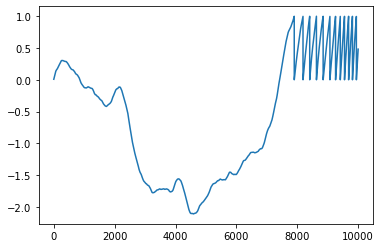

In [28]:
plot(State_s.v[0, :])


### Plotting Functions

#### Spike Rasters

In [ ]:
def spike_raster():
    eventplot()


In [29]:
plotting.base.brian_plot(M_n)

AttributeError: 'function' object has no attribute 'base'

Text(0.5, 1.0, 'P_n Raster Plot')

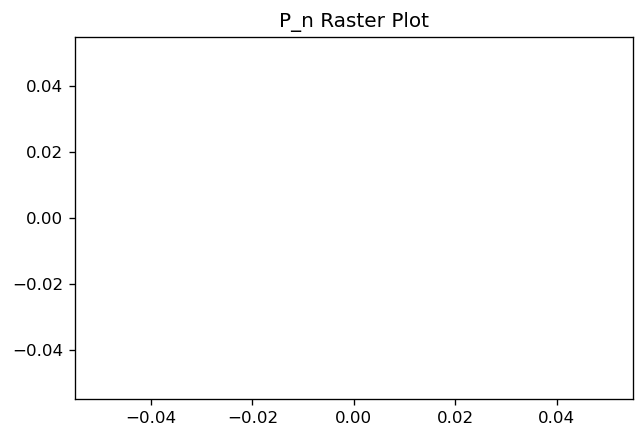

In [22]:
figure(dpi=120)
plot(M_n.t/ms, M_n.i, '.k', markersize=1)
title("P_n Raster Plot")

Text(0.5, 1.0, 'P_s Raster Plot')

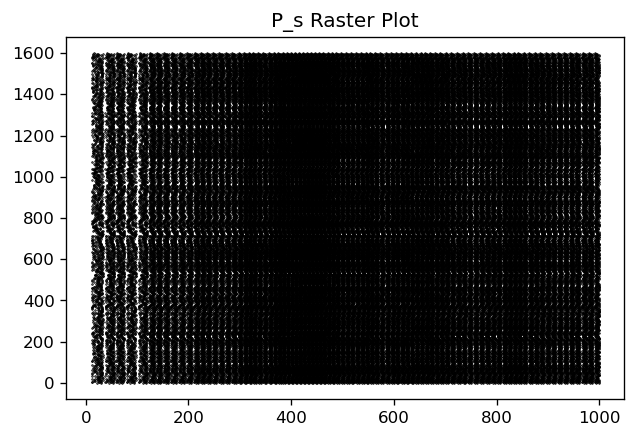

In [23]:
figure(dpi=120)
plot(M_s.t/ms, M_s.i, '.k', markersize=0.9)
title("P_s Raster Plot")

Text(0.5, 1.0, 'P_e Raster Plot')

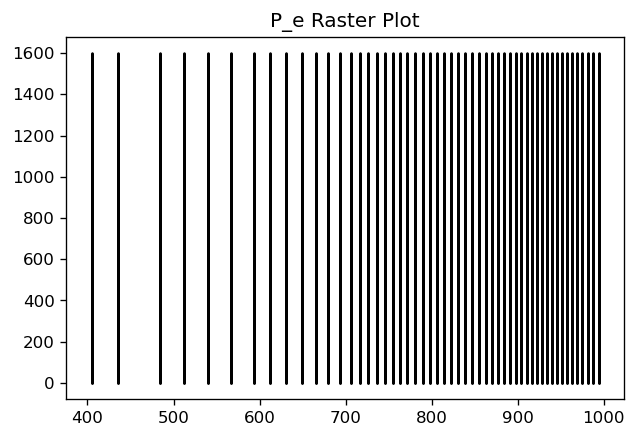

In [24]:
figure(dpi=120)
plot(M_e.t/ms, M_e.i, '.k', markersize=0.9)
title("P_e Raster Plot")

Text(0.5, 1.0, 'P_w Raster Plot')

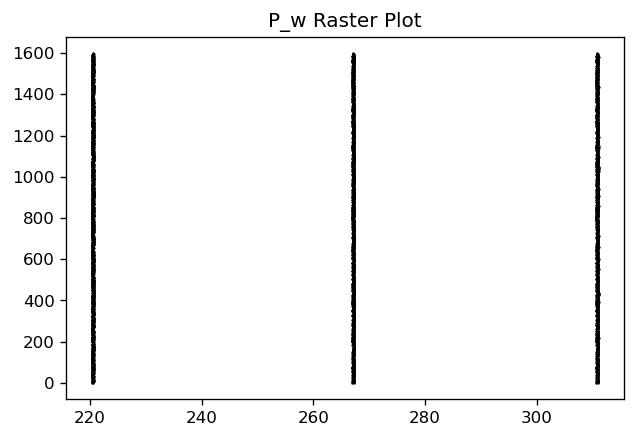

In [25]:
figure(dpi=120)
plot(M_w.t/ms, M_w.i, '.k', markersize=0.9)
title("P_w Raster Plot")

Text(0.5, 1.0, 'P_i Raster Plot')

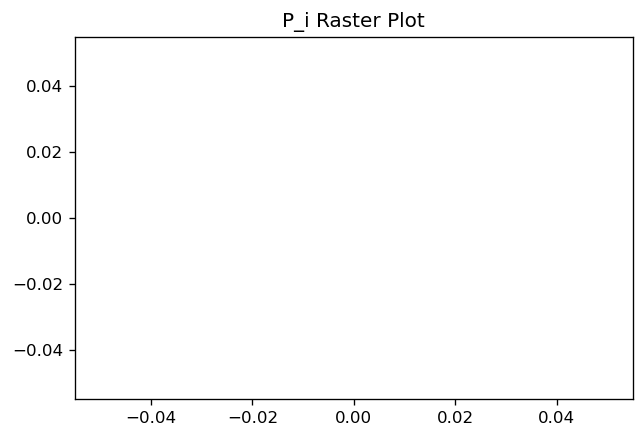

In [26]:
figure(dpi=120)
plot(M_i.t/ms, M_i.i, '.k', markersize=0.9)
title("P_i Raster Plot")

#### Neural Dynamics Plots

1. Plot membrane potential heatmap animation:

        Membrane potential image plot as a time-series animation
2. Plot spikemap animation:

        Spike on a x-y plot corresponding to their location

In [27]:
for i in range(N):
plot(State_n.v[10])

IndentationError: expected an indented block (1826580864.py, line 2)

In [28]:
int(duration/defaultclock.dt)

10000

In [29]:
t = 0
# Create 2-D Matrix consisting of membrane potential
Potential_n = empty((n, n, int(duration/defaultclock.dt)))
print("Creating potential heatmap array")
for i in tqdm(range(N)):
    x = int(i % n)
    y = i // n
    Potential_n[x, y, :] = State_n.v[i]


Creating potential heatmap array


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:52<00:00, 30.73it/s]


Plotting potential heatmap


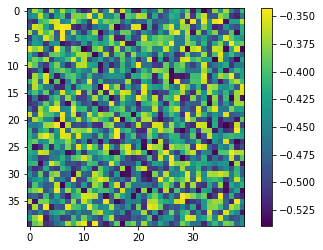

In [30]:
print("Plotting potential heatmap")
imshow(Potential_n[:, :, 650])
colorbar()

MovieWriter stderr:
[libopenh264 @ 0x55ab996902c0] Incorrect library version loaded
Error initializing output stream 0:0 -- Error while opening encoder for output stream #0:0 - maybe incorrect parameters such as bit_rate, rate, width or height



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '432x288', '-pix_fmt', 'rgba', '-r', '5', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'increasingStraightLine.mp4']' returned non-zero exit status 1.

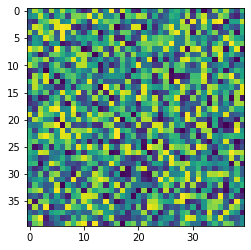

In [40]:
fig = plt.figure()
ax = plt.axes()

def ani_potential_heatmap(i):
    """
    Draws each frame of the animation
    """
    time_bin = i # the theta cycle to plot activity
    module_no = 1
    
    fig.clear()
    imshow(Potential_n[:, :, time_bin])
    draw()

anim = FuncAnimation(fig, ani_potential_heatmap, frames=100, interval=500)

writervideo = animation.FFMpegWriter()
anim.save('increasingStraightLine.mp4', writer=writervideo)


#### 